<a href="https://colab.research.google.com/github/naufalnashif/sentiment-analysis-biskita/blob/main/biskita_ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

## About this project

1. Data is collected from Twitter with scraping method. Tool is used is Python with Snscrape module and I use two keywords 'Biskita' and 'Transpakuan'. The total is 4304 tweets scraped from June, 26th 2022 to June, 25th 2023.
2.  The models I will build with Ensemble method with three base classifiers.
- Multinomial Logistics Regression
- Multinomial Naive Bayes
- Random Forest
And three prediction classes (Negative, Neutral and Positive)
3. The application result was deployed on Hugigngface, u can see the demo on *https://huggingface.co/spaces/naufalnashif/sentiment-analysis-ensemble-model*

### Summary Results

...

## Install and Import Dependencies

### Install Dependencies

In [ ]:
!pip install pandas numpy tqdm regex jsons nltk sastrawi matplotlib seaborn wordcloud collection
!pip install git+https://github.com/JustAnotherArchivist/snscrape.git

### Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
from tqdm.notebook import tqdm

import re

import json

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.tokenize import word_tokenize
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import PorterStemmer

### Scraping Syntax
*FOR NOW snscrape is not work*

In [ ]:
# Scraping with keyword 'biskita'
scrapper = sntwitter.TwitterSearchScraper("biskita until:2023-06-25 since:2022-06-26")

tweets = []
n_tweets = 5_000
for i,tweet in tqdm(enumerate(scrapper.get_items()), total=n_tweets):
  data = [
    tweet.date,
    tweet.id,
    tweet.rawContent,
    tweet.user.username,
    tweet.likeCount,
    tweet.retweetCount,
  ]
  tweets.append(data)
  if i > n_tweets :
    break

df_bis_2023 = pd.DataFrame(
    tweets, columns=["date", "id", "content", "username", "like_count", "retweet_count" ]
)
df_bis_2023.to_csv('Biskita_2023.csv')

In [ ]:
scrapper = sntwitter.TwitterSearchScraper("transpakuan until:2023-06-25 since:2022-06-26")

tweets = []
n_tweets = 5_000
for i,tweet in tqdm(enumerate(scrapper.get_items()), total=n_tweets):
  data = [
    tweet.date,
    tweet.id,
    tweet.rawContent,
    tweet.user.username,
    tweet.likeCount,
    tweet.retweetCount,
  ]
  tweets.append(data)
  if i > n_tweets :
    break

df_trans_2023 = pd.DataFrame(
    tweets, columns=["date", "id", "content", "username", "like_count", "retweet_count" ]
)
df_trans_2023.to_csv('Transpakuan_2023.csv')

In [ ]:
# Append/Concat the data
#Because snscrape is not working, i was imported the data
df_bis_2023 = pd.read_csv('datasets/Biskita_2023.csv')
df_trans_2023 = pd.read_csv('datasets/Transpakuan_2023.csv')
df_bisTrans = df_bis_2023.append(df_trans_2023)

In [ ]:
# Save to csv file
df_bisTrans.to_csv('datasets/bis-trans_2023.csv', index = False)

## Data Preprocessing

### Data Cleaning

In [ ]:
file_path = 'datasets/labelling-sept.csv'
df_labels = pd.read_csv(file_path)
df_labels.head(2)

,date,id,Unnamed: 2,tweets,username,like_count,retweet_count,perbedaan,label-1,label-2,label-3,label-fix,Unnamed: 12,942,904,788,943
0,2023-06-24 14:59:42,1.672620e+18,NaN,angkot berguna soalnya yakali lu dr bogor ampe...,ayangwendy,0,0,0.0,Negatif,Negatif,Negatif,Negatif,NaN,409.0,404.0,334.0,409.0
1,2023-06-24 12:32:09,1.672580e+18,NaN,"ah lama bgt inimahh, nunggu biskita dateng",gagaxputih,0,0,0.0,Negatif,Negatif,Negatif,Negatif,NaN,NaN,NaN,NaN,NaN


In [ ]:
# RegEx Function
def apply_regex_cleaning(text):
    # Tahap-1: Non-ascii
    res = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Tahap-2: URLs
    res = re.sub(r'http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+', ' ', res)
    res = re.sub(r'pic.twitter.com?.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+', ' ', res)
    # Tahap-3: mentions
    res = re.sub(r'\@([\w]+)', ' ', res)
    # Tahap-4_alt-1: hapus tagar
    res = re.sub(r'\#([\w]+)', ' ', res)
    # Menghapus 'amp' yang menempel pada '&' dan 'gt' yang menempel pada '&'
    res = re.sub(r'&amp;|&gt;', '', res)
    # Tahap-6: simbol
    res = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', res)
    # Tahap-7: angka
    res = re.sub(r'[0-9]+', '', res)
    # Tahap-8: koreksi duplikasi tiga karakter beruntun atau lebih (contoh. yukkk)
    res = re.sub(r'([a-zA-Z])\1\1', '\\1', res)
    # Tahap-9 Menghapus kata 'bgr', 'cc', 'rp', dan lain - lain
    res = re.sub(r'\b(cc|rp|k|x|y)\b', '', res, flags=re.IGNORECASE)
    res = re.sub(r'\btrans\s+pakuan\b', 'transpakuan', res)
    # Tahap-10: spasi ganda (atau lebih) menjadi satu spasi
    res = re.sub(' +', ' ', res)
    # Tahap-11: spasi di awal dan akhir kalimat
    res = re.sub(r'^[ ]|[ ]$', '', res)
    # Tahap-12: konversi ke karakter huruf kecil
    res = res.lower()
    # Tahap-13: koreksi duplikasi tiga karakter beruntun atau lebih (contoh. yukkk)
    res = re.sub(r'([a-zA-Z])\1\1', '\\1', res)

    return res

In [ ]:
# Loop function to get by tweet
def clean_column_with_regex(file_path, column_name):
    try:
        df = pd.read_csv(file_path)
        column_data = df[column_name]
        cleaned_data = [apply_regex_cleaning(text) for text in column_data]

        cleaned_df = pd.DataFrame({column_name: cleaned_data})
        cleaned_file_path = 'datasets/tweets-cleaned.csv'
        cleaned_df.to_csv(cleaned_file_path, index=False)

        print(f"Data cleaned and saved to {cleaned_file_path}")
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
#Execute
def main():
    file_path = 'datasets/labelling-sept.csv'
    column_name_to_clean = 'tweets'  # Ganti dengan nama kolom yang ingin Anda bersihkan

    try:
        clean_column_with_regex(file_path, column_name_to_clean)
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

Data cleaned and saved to datasets/tweets-cleaned.csv


In [ ]:
file_path_cleaned = 'datasets/tweets-cleaned.csv'
df_cleaned = pd.read_csv(file_path_cleaned)
df_cleaned['tweets-cleaned'] = df_cleaned['tweets']
df_cleaned = df_cleaned.drop(columns= 'tweets')

# Combined df_cleaned with datasets
combined_df = pd.concat([df_labels[['date', 'id', 'username', 'like_count', 'retweet_count', 'label-fix', 'tweets']], df_cleaned], axis=1)

In [ ]:
output_cleaned_path = 'datasets/tweets-cleaned.csv'
combined_df.to_csv(output_cleaned_path, index=False)

### Normalization Words

In [ ]:
# THIS CASE WHEN YOUR KERNEL CONNECTING AGAIN, YOU CAN BEGIN FROM THIS STAGE
# Mengimpor data CSV
output_cleaned_path = 'datasets/tweets-cleaned.csv'
df = pd.read_csv(output_cleaned_path)

# Membaca kamus kata gaul Salsabila
kamus_path = 'assets/_json_colloquial-indonesian-lexicon.txt'
with open(kamus_path) as f:
    data = f.read()
lookp_dict = json.loads(data)

In [ ]:
# Custom slang dict to adjust the topic

kamus_gaul_baru = {
    'kurangg': 'kurang',
    'udaa': 'udah',
    'mnurut': 'menurut',
    'anyinh': 'anjing',
    'seputat': 'seputar',
    'ijo'	 : 'hijau',
    'dmma'	: 'dimana',
    'anjrot'	: 'anjing',
    'ajgg'	: 'anjing',
    'keboen'	: 'kebun',
    'aseekk'	: 'asik',
    'bliau' :	'beliau',
    'aseek' :	'asik',
    'berpaa' :	'berapa',
    'berpa' :	'berapa',
    'bggtt' :	'banget',
    'cntoh' :	'contoh',
    'anzink'	: 'anjing',
    'jrg' :	'jarang',
    'msi' :	'masih',
    'anjirt' :	'anjing',
    'kesampeian' :	'kesampaian',
    'dtgnya' :	'datangnya',
    'dtg' :	'datang',
    'dngin' :	'dingin',
    'ktub' :	'kutub',
    'brngkt' : 'berangkat',
    'antra'	: 'antara',
    'pinuh': 'penuh',
    'anjink': 'anjing',
    'anjir' : 'anjing',
    'ajg': 'anjing',
    'smpet': 'sempat',
    'sempet': 'sempat',
    'makai': 'memakai',
    'bgst': 'bangsat',
    'anjg': 'anjing',
    'cpk': 'lelah',
    'capek': 'lelah',
    'capk': 'lelah',
    'cpek': 'lelah',
    'anjrit': 'anjing',
    'anjig': 'anjing',
    'anjigg': 'anjing',
    'anjingg': 'anjing',
    'bukann': 'bukan',
    'skrgg': 'sekarang',
    'makasihh': 'terimakasih',
    'asu': 'anjing',
    'moga': 'semoga',
    'cok': 'jancok',
    'cokk': 'jancok',
    'cook': 'jancok',
    'cookk': 'jancok',
    'amgkot': 'angkot',
    'gua' : 'aku',
    'gweh': 'aku',
    'guah': 'aku',
    'gw': 'aku',
    'gwah': 'aku',
    'gue' : 'aku',
    'wkwkwk' : 'wkwk',
    'dah' : 'udah',
    'tkt' : 'takut',
    'gabisa' : 'gabisa',
    'umumm' : 'umum',
    'umuum' : 'umum',
    'yah' : 'yah',
    'drtd' : 'daritadi',
    'drtdi' : 'daritadi',
    'ges':'gais',
    'gays': 'gais',
    'geys':'gais',
    'trans pakuan': 'transpakuan',
    'anjr' : 'anjir',
    'anjer' : 'anjing',
    'njir' : 'anjing',
    'anjr' : 'anjing',
    'trans pakuan' : 'transpakuan',
    'gblk' : 'goblok',
}


In [ ]:
# Update dict
lookp_dict.update(kamus_gaul_baru)

In [ ]:
def replace_with_slang(text, slang_dict):
    if isinstance(text, str):  # Memeriksa apakah nilai teks bukan NaN
        return " ".join(slang_dict.get(word, word) for word in text.split())
    return text  # Mengembalikan nilai NaN tanpa mengubahnya

# Mengganti kata-kata dalam kolom 'cleaned-content' dengan kata-kata dalam kamus
df['tweets-norm'] = df['tweets-cleaned'].apply(lambda x: replace_with_slang(x, lookp_dict))

# Menyimpan hasil ke file Excel baru
output_norm_path = 'datasets/normalisasi-tweets.csv'
df.to_csv(output_norm_path, index=False)

### Stopwords Removal

In [ ]:
# Tambahkan kata-kata tambahan ke kamus stopwords
additional_stopwords = []  # Ganti dengan kata-kata yang ingin Anda tambahkan
stop_words = set(stopwords.words('indonesian'))
stop_words.update(additional_stopwords)

# Hapus beberapa kata dari kamus stopwords agar tidak terhapus pada tweets
words_to_remove = ['lama', 'datang', 'sekarang', 'amat',  'usah', 'tidak',  'percuma',  'jauh', 'demi', 'apa', 'mana', 'begini', 'waktu', 'kurang', 'ya', 'kah', 'bagaimana', 'gimana','tanya','mau','berapa','jadwal','belum','gamau','dimana','kalo','info','sih','punten','naik','gais','min','ga','bisa','apa' ]
for word in words_to_remove:
    if word in stop_words:
        stop_words.remove(word)

print("Updated stopwords list:", stop_words)
len(stop_words)

In [ ]:

norm_output = 'datasets/normalisasi-tweets.csv'
output_file_stopw = "datasets/stopword-removal.csv"

data = pd.read_csv(norm_output)
column_name = "tweets-norm"  # Change this to the actual column name

# Process the data and remove stopwords
def remove_stopwords(line):
    if isinstance(line, str):
        return " ".join([word for word in line.split() if word not in stop_words])
    return line

data['stopwords-remove'] = data[column_name].apply(remove_stopwords)

# Save the processed data to a new Excel file
data.to_csv(output_file_stopw, index=False)

print("Stopwords removed and saved to", output_file_stopw)

Stopwords removed and saved to datasets/stopword-removal.csv


### Stemming

In [ ]:
# Membuat objek stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Load data dari file XLSX
stopw_output =   "datasets/stopword-removal.csv"
output_file_stem = "datasets/stemmed-tweets.csv"

# Membaca data dari file XLSX
data = pd.read_csv(stopw_output)

In [ ]:
# Define a function to perform stemming
def stem_sentence(sentence):
    words = sentence.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Apply stemming to the 'stopwords-remove' column, handling NaN values
data['stemmed_tweets'] = data['stopwords-remove'].apply(lambda x: stem_sentence(x) if pd.notnull(x) else '')

# Save the stemmed data to XLSX file
data.to_csv(output_file_stem, index=False)

print("Stemmed tweets saved to", output_file_stem)

Stemmed tweets saved to datasets/stemmed-tweets.csv


### Tokenization

In [ ]:
# Load data from XLSX file
stem_output = "datasets/stemmed-tweets.csv"
output_file = "datasets/tokenized_tweets.csv"

# Read data from XLSX file
data = pd.read_csv(stem_output)

In [ ]:
# Pastikan semua nilai dalam kolom "content" adalah string
data['stemmed_tweets'] = data['stemmed_tweets'].astype(str)

def tokenize_sentence(sentence):
    tokens = word_tokenize(sentence)
    return tokens

# Melakukan tokenisasi
data['tokenized_content'] = data['stemmed_tweets'].apply(tokenize_sentence)


In [ ]:
# Pastikan semua nilai dalam kolom "content" adalah string
data['stopwords-remove'] = data['stopwords-remove'].astype(str)

def tokenize_sentence(sentence):
    tokens = word_tokenize(sentence)
    return tokens

# Melakukan tokenisasi
data['tokenized_without_stemmed'] = data['stopwords-remove'].apply(tokenize_sentence)

In [ ]:
# Save the tokenized data to XLSX file
data.to_csv(output_file, index=False)

print("Tokenized tweets saved to", output_file)

Tokenized tweets saved to datasets/tokenized_tweets.csv


## Exploratory Data Analysis (EDA)

### Data Information

In [ ]:
# Load the data from an Excel file (assuming 'data.xlsx' is the file name)
data_with_duplicates = pd.read_csv('datasets/bis-trans_2023.csv')

#drop duplicates was applied to the data
data = pd.read_csv('datasets/tokenized_tweets.csv')

In [ ]:
print(data_with_duplicates.shape)
print(data.shape)

(4306, 7)
(4094, 12)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               4094 non-null   object 
 1   id                 4094 non-null   float64
 2   username           4094 non-null   object 
 3   like_count         4094 non-null   int64  
 4   retweet_count      4094 non-null   int64  
 5   label-fix          4094 non-null   object 
 6   tweets             4094 non-null   object 
 7   tweets-cleaned     4090 non-null   object 
 8   tweets-norm        4090 non-null   object 
 9   stopwords-remove   4090 non-null   object 
 10  stemmed_tweets     4090 non-null   object 
 11  tokenized_content  4094 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 383.9+ KB


In [ ]:
data.isnull().sum()

date                 0
id                   0
username             0
like_count           0
retweet_count        0
label-fix            0
tweets               0
tweets-cleaned       4
tweets-norm          4
stopwords-remove     4
stemmed_tweets       4
tokenized_content    0
dtype: int64

In [ ]:

# Remove rows labeled as 'spam'
#data = data[data['label-fix'] != 'Spam/Hapus']

# Drop rows with NaN values in any column
data = data.dropna()
data.shape

(4090, 12)

In [ ]:
label_counts = data['label-fix'].value_counts()
print(label_counts)

Netral        1597
Positif       1145
Negatif        943
Spam/Hapus     405
Name: label-fix, dtype: int64


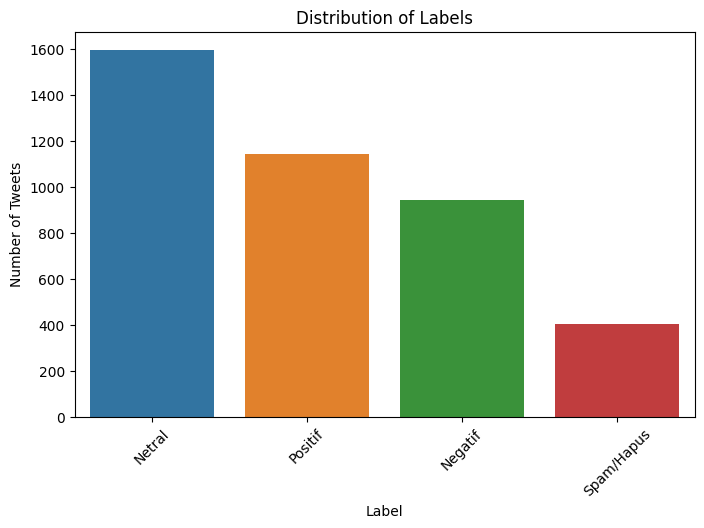

In [ ]:
# Plot a bar chart of label distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Count the number of unique usernames
# Using data_without labels, because contain duplicates
num_unique_users_with_duplicates = data_with_duplicates['username'].nunique()
print(f"Number of unique usernames: {num_unique_users_with_duplicates}")

num_unique_users = data['username'].nunique()
print(f"Number of unique usernames: {num_unique_users}")

Number of unique usernames: 2150
Number of unique usernames: 2149


<Axes: title={'center': 'Counts of Tweet'}>

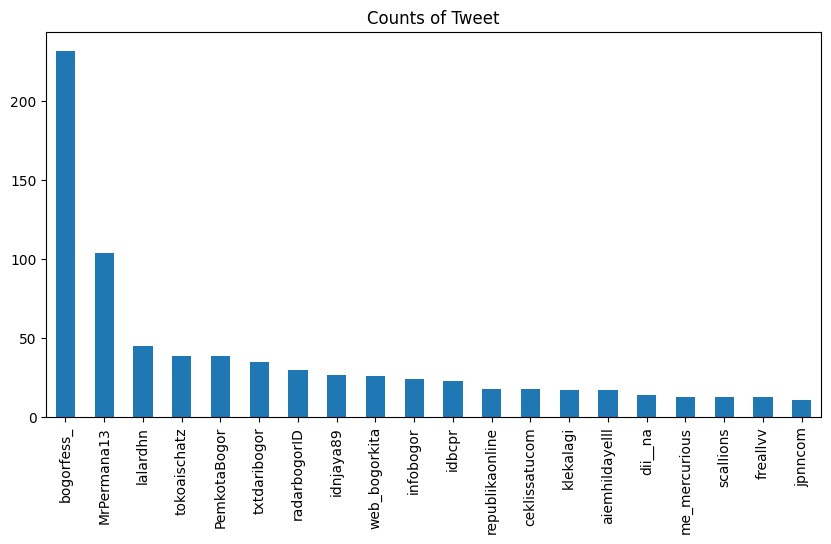

In [ ]:
#Visualize tweets count by username, conatin duplicates
data_with_duplicates['username'].value_counts().head(20).plot(kind = 'bar', title = 'Counts of Tweet', figsize = (10,5))

In [ ]:
#Before After drop duplicates

#df_drop = data_with_duplicates.drop_duplicates(subset = ['content'])
print('Sebelum drop duplicates : {} tweets'.format(len(data_with_duplicates)))
print('Sesudah drop duplicates : {} tweets'.format(len(data)))
print('Total tweet terhapus : {} tweets'.format(len(data_with_duplicates) - len(data)))

Sebelum drop duplicates : 4306 tweets
Sesudah drop duplicates : 4094 tweets
Total tweet terhapus : 212 tweets


<Axes: title={'center': 'Counts of Tweet'}>

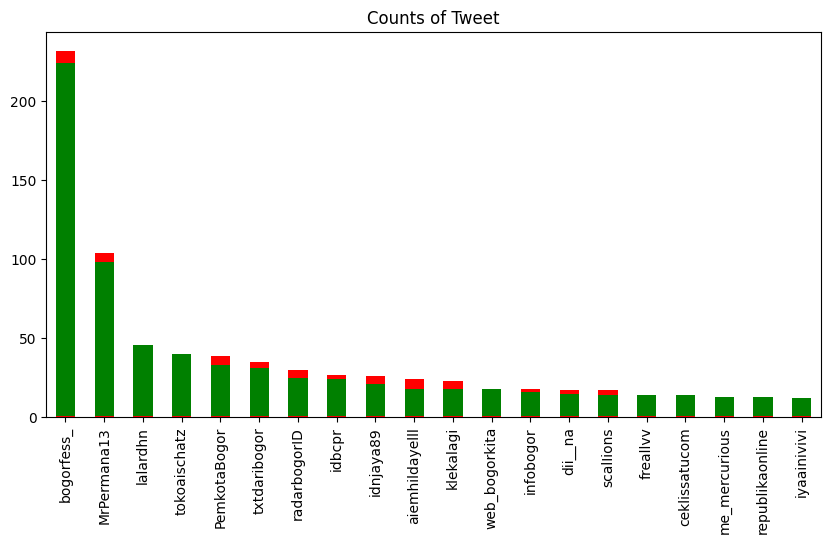

In [ ]:
# Visualize duplicates by username
data_with_duplicates['username'].value_counts().head(20).plot(kind = 'bar', title = 'Counts of Tweet', figsize = (10,5), color = 'r')
data['username'].value_counts().head(20).plot(kind = 'bar', title = 'Counts of Tweet', figsize = (10,5), bottom = True, color = 'g')

In [ ]:
df_dupl = data_with_duplicates[data_with_duplicates.duplicated(subset = ['content'])]
df_dupl.head()

,Unnamed: 0,date,id,content,username,like_count,retweet_count
10,10,2023-06-23 15:15:39+00:00,1672262147097919489,halo kakak2 yg domisili kota bogor atau kerja ...,agapatri,0,0
866,866,2023-04-10 05:49:41+00:00,1645303012242640897,"[bgr] mau nanya dong, biskita masih gratis ata...",bogorfess_,1,0
893,893,2023-04-05 15:39:24+00:00,1643639483219230722,"[bgr] mau nanya dong, biskita masih gratis ata...",bogorfess_,0,0
982,982,2023-04-01 04:06:19+00:00,1642015510362738690,"@bogorfess_ sorry oot, ada yg tau cara naik bi...",paboppaa,0,0
1387,1387,2023-02-07 08:10:01+00:00,1622870280950673411,[bgr] biskita masih gratis kan ya?,bogorfess_,2,0


#### SPAM Indicated
- MrPermana13
- idbcpr
- idnjaya89
- aiemhildayell
- klekalagi
- dii_na
- scallions

In [ ]:
#df_dupl = data_with_duplicates[data_with_duplicates.duplicated(subset = ['content'])]
#MrPermana13 = df_dupl[df_dupl['username']=='MrPermana13']
#idbcpr = df_dupl[df_dupl['username']=='idbcpr']
#idnjaya89 = df_dupl[df_dupl['username']=='idnjaya89']
#aiemhildayell = df_dupl[df_dupl['username']=='aiemhildayell']
#klekalagi = df_dupl[df_dupl['username']=='klekalagi']
#dii_na = df_dupl[df_dupl['username']=='dii_na']
#scallions = df_dupl[df_dupl['username']=='scallions']

### EDA with stopwords column

#### All Class

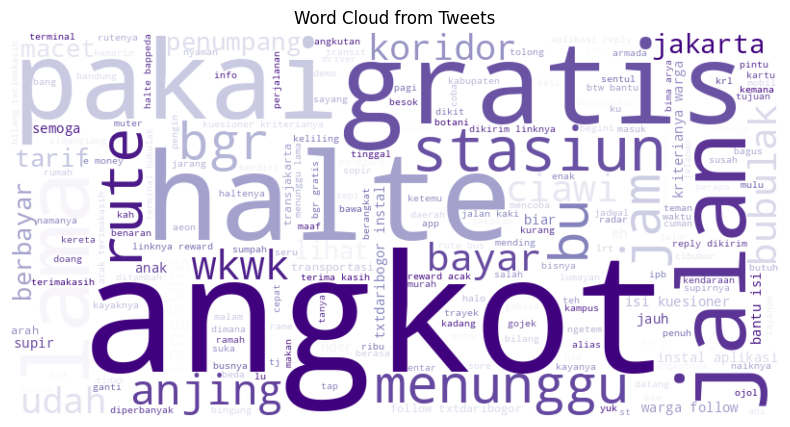

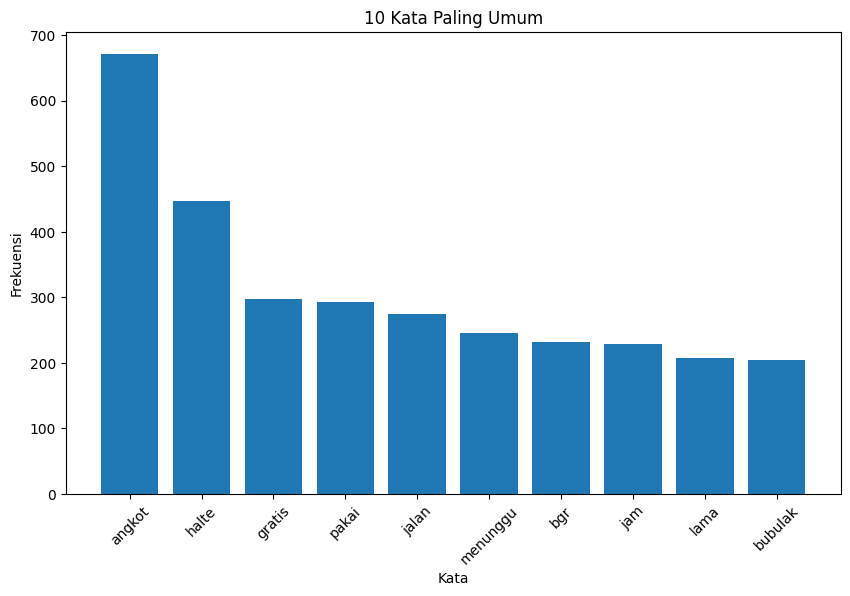

[('angkot', 671), ('halte', 447), ('gratis', 297), ('pakai', 293), ('jalan', 275), ('menunggu', 245), ('bgr', 232), ('jam', 229), ('lama', 208), ('bubulak', 205)]


In [ ]:
# Concatenate all tweets into a single string
all_tweets_text = ' '.join(data['tokenized_without_stemmed'])  # Replace 'tweet_column_name' with the actual column name in your data
#cleaned_text = re.sub(r"['\[\],]", "", all_tweets_text)
# Flatten the list of lists into a single list of strings
#all_tweets_tokens = [token for sublist in data['tokenized_without_stemmed'] for token in sublist]

# Join the tokens into a single string
#all_tweets_text = ' '.join(all_tweets_tokens)

# Remove unwanted characters
cleaned_text = re.sub(r"['\[\],]", "", all_tweets_text)

remove_words = ['transpakuan', 'pakuan', 'trans', 'naik', 'biskita', 'mah', 'pulang', 'tumpang', 'duduk', 'habis', 'bagaimana', 'kali', 'banget', 'tuh', 'turun', 'menit',  'bikin', 'nih',   'gue', 'kalo', 'ya', 'bisa', 'mau', 'bogor', 'sih', 'kayak', 'bis', 'deh', 'mana', 'orang', 'nya', 'kak', 'n', 'bar', 'gua', 'pas', 'belum', 'apa', 'tau', 'kota', 'sekarang']
cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in remove_words])



# Create a WordCloud object
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='Purples',   # Warna huruf
                      contour_color='black',  # Warna kontur
                      contour_width=2,       # Lebar kontur
                      mask=None,             # Gunakan mask untuk bentuk kustom
                      ).generate(cleaned_text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud from Tweets')
plt.axis('off')
plt.show()


words = cleaned_text.split()

word_counts = Counter(words)

# Mengambil 10 kata paling umum
most_common_words = word_counts.most_common(10)

# Memisahkan kata dan frekuensi ke dalam dua list terpisah
common_words, common_counts = zip(*most_common_words)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(common_words, common_counts)
plt.title('10 Kata Paling Umum')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()


print(most_common_words)

#### Negative Class

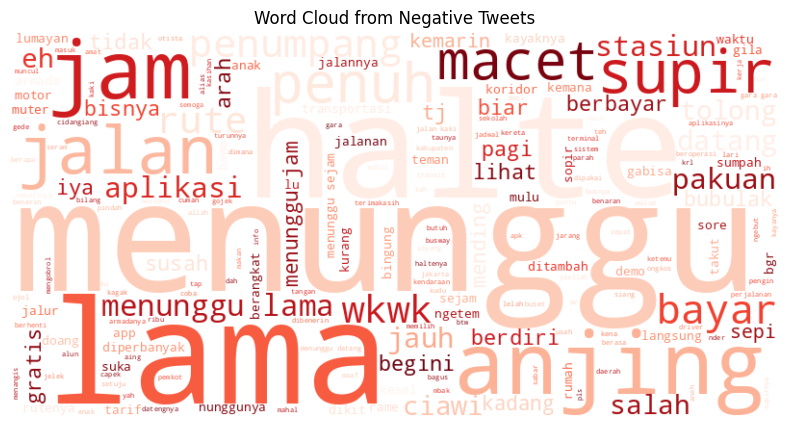

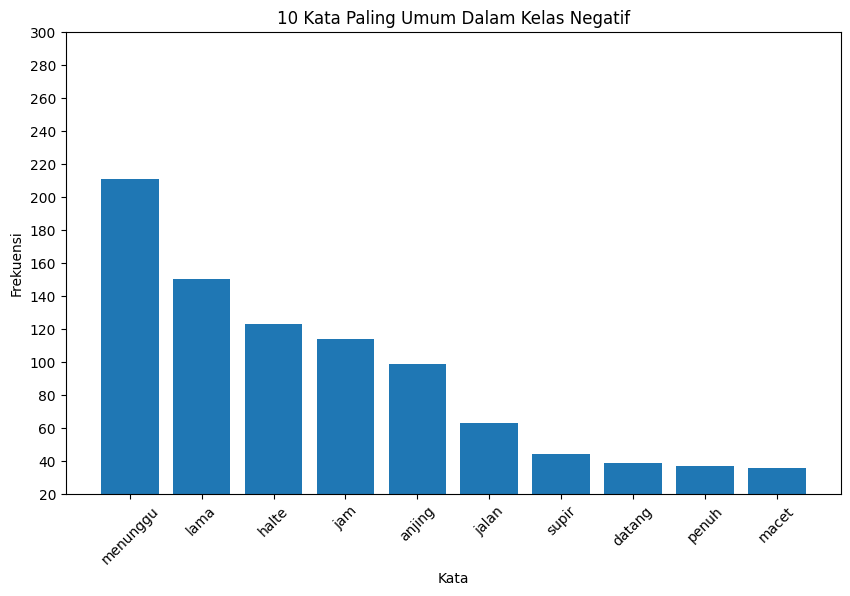

[('menunggu', 211), ('lama', 150), ('halte', 123), ('jam', 114), ('anjing', 99), ('jalan', 63), ('supir', 44), ('datang', 39), ('penuh', 37), ('macet', 36)]


In [ ]:
# Concatenate all tweets into a single string
negatif_data = data[data['label-fix'] == 'Negatif']


# Concatenate all tweets into a single string
all_tweets_text_neg = ' '.join(negatif_data['tokenized_without_stemmed'])  # Replace 'tweet_column_name' with the actual column name in your data

# Flatten the list of lists into a single list of strings
#all_tweets_text_neg = [token for sublist in negatif_data['tokenized_without_stemmed'] for token in sublist]
#cleaned_text_neg = ' '.join(all_tweets_text_neg)

# Remove unwanted characters
#cleaned_text_neg = re.sub(r"['\[\],]", "", cleaned_text_neg)
cleaned_text_neg = re.sub(r"['\[\],]", "", all_tweets_text_neg)

# Mengabaikan kata 'banget' dan 'angkot'
remove_words = ['udah','mah', 'pulang', 'tumpang', 'duduk', 'habis', 'bagaimana', 'kali', 'banget', 'tuh', 'turun', 'trans', 'menit', 'paku', 'bikin', 'nih', 'angkot', 'biskita', 'naik', 'gue', 'kalo', 'ya', 'bisa', 'mau', 'bogor', 'sih', 'kayak', 'bis', 'deh', 'mana', 'orang', 'nya', 'kak', 'n', 'bar', 'gua', 'pas', 'belum', 'apa', 'tau', 'pakai', 'transpakuan', 'bus', 'kota', 'sekarang']
cleaned_text_neg = ' '.join([word for word in cleaned_text_neg.split() if word not in remove_words])


# Create a WordCloud object
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text_neg)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='Reds',   # Warna huruf
                      contour_color='black',  # Warna kontur
                      contour_width=2,       # Lebar kontur
                      mask=None,             # Gunakan mask untuk bentuk kustom
                      ).generate(cleaned_text_neg)


# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud from Negative Tweets')
plt.axis('off')
plt.show()

words = cleaned_text_neg.split()

word_counts = Counter(words)

# Mengambil 20 kata paling umum
most_common_words = word_counts.most_common(10)

# Memisahkan kata dan frekuensi ke dalam dua list terpisah
common_words, common_counts = zip(*most_common_words)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(common_words, common_counts)
plt.title('10 Kata Paling Umum Dalam Kelas Negatif')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
# Mengatur rentang dan jarak pada sumbu Y
plt.ylim(20, 300)
plt.yticks(np.arange(20, 301, 20))

plt.xticks(rotation=45)
plt.show()

print(most_common_words)

#### Neutral Class

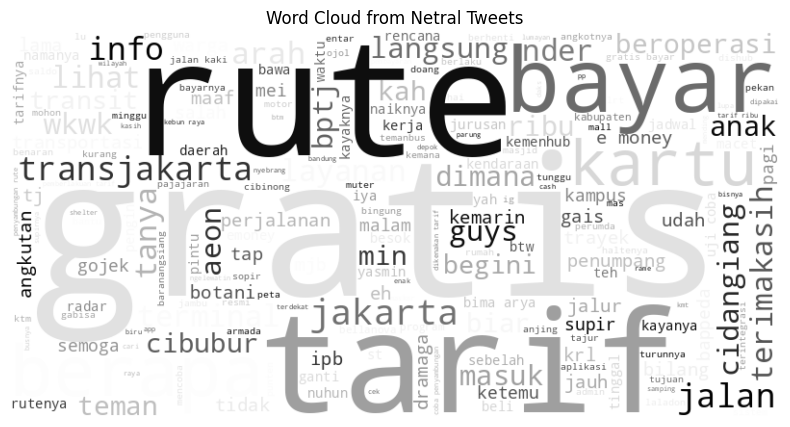

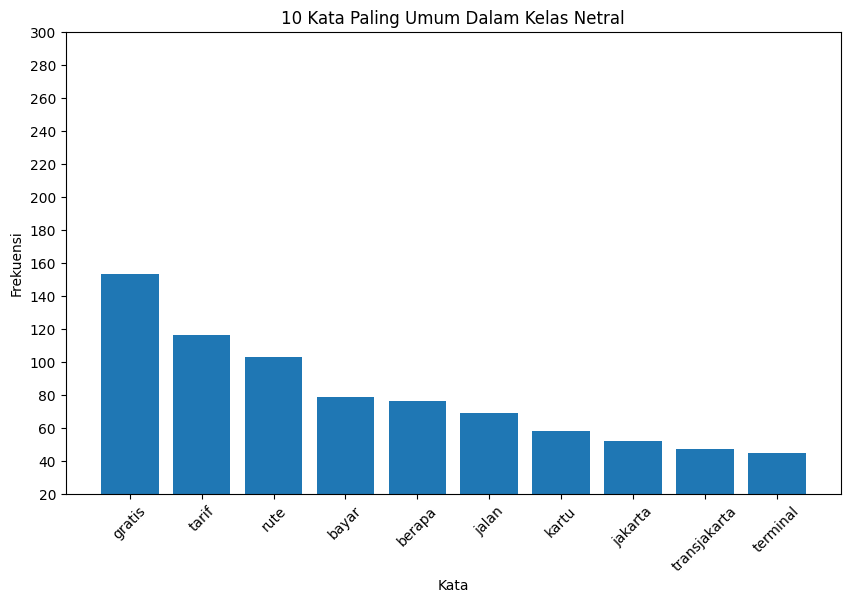

[('gratis', 153), ('tarif', 116), ('rute', 103), ('bayar', 79), ('berapa', 76), ('jalan', 69), ('kartu', 58), ('jakarta', 52), ('transjakarta', 47), ('terminal', 45)]


In [ ]:
# Concatenate all tweets into a single string
netral_data = data[data['label-fix'] == 'Netral']

# Flatten the list of lists into a single list of strings
#all_tweets_text_net = [token for sublist in netral_data['tokenized_without_stemmed'] for token in sublist]
#cleaned_text_net = ' '.join(all_tweets_text_net)

# Concatenate all tweets into a single string
all_tweets_text_net = ' '.join(netral_data['tokenized_without_stemmed'])  # Replace 'tweet_column_name' with the actual column name in your data


# Remove unwanted characters
#cleaned_text_net = re.sub(r"['\[\],]", "", cleaned_text_net)
cleaned_text_net = re.sub(r"['\[\],]", "", all_tweets_text_net)

# Mengabaikan kata 'banget' dan 'angkot'
remove_words = ['bgr', 'bubulak', 'sentul','berbayar','jam','ciawi', 'stasiun','pakuan', 'halte', 'koridor','mah', 'pulang', 'tumpang', 'duduk', 'habis', 'bagaimana', 'kali', 'banget', 'tuh', 'turun', 'trans', 'menit', 'paku', 'bikin', 'nih', 'angkot', 'biskita', 'naik', 'gue', 'kalo', 'ya', 'bisa', 'mau', 'bogor', 'sih', 'kayak', 'bis', 'deh', 'mana', 'orang', 'nya', 'kak', 'n', 'bar', 'gua', 'pas', 'belum', 'apa', 'tau', 'pakai', 'transpakuan', 'bus', 'kota', 'sekarang']

cleaned_text_net = ' '.join([word for word in cleaned_text_net.split() if word not in remove_words])


# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text_net)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='Greys',   # Warna huruf
                      contour_color='black',  # Warna kontur
                      contour_width=2,       # Lebar kontur
                      mask=None,             # Gunakan mask untuk bentuk kustom
                      ).generate(cleaned_text_net)



# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud from Netral Tweets')
plt.axis('off')
plt.show()

words = cleaned_text_net.split()

word_counts = Counter(words)

# Mengambil 20 kata paling umum
most_common_words = word_counts.most_common(10)

# Memisahkan kata dan frekuensi ke dalam dua list terpisah
common_words, common_counts = zip(*most_common_words)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(common_words, common_counts)
plt.title('10 Kata Paling Umum Dalam Kelas Netral')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
# Mengatur rentang dan jarak pada sumbu Y
plt.ylim(20, 300)
plt.yticks(np.arange(20, 301, 20))

plt.xticks(rotation=45)
plt.show()

print(most_common_words)

#### Positive Class

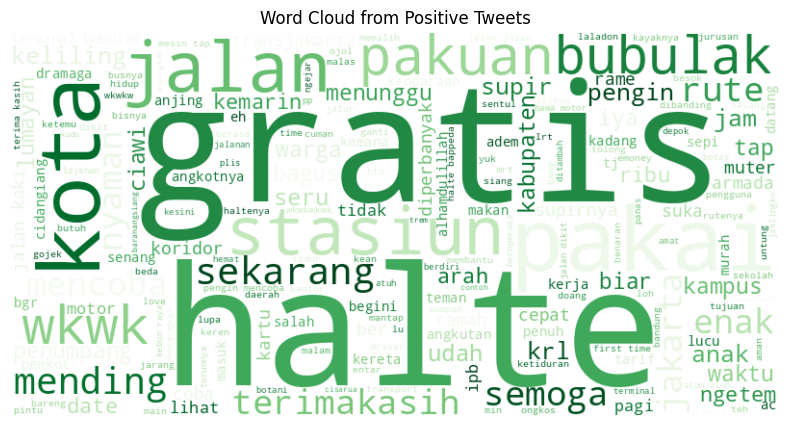

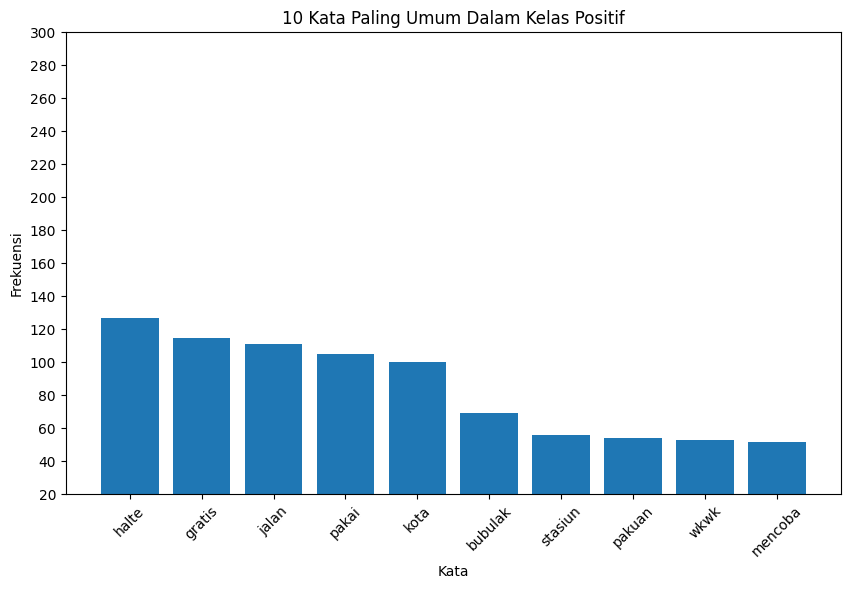

[('halte', 127), ('gratis', 115), ('jalan', 111), ('pakai', 105), ('kota', 100), ('bubulak', 69), ('stasiun', 56), ('pakuan', 54), ('wkwk', 53), ('mencoba', 52)]


In [ ]:
# Concatenate all tweets into a single string
positif_data = data[data['label-fix'] == 'Positif']

# Concatenate all tweets into a single string
all_tweets_text_pos = ' '.join(positif_data['tokenized_without_stemmed'])  # Replace 'tweet_column_name' with the actual column name in your data


# Flatten the list of lists into a single list of strings
#all_tweets_text_pos = [token for sublist in positif_data['tokenized_without_stemmed'] for token in sublist]
#cleaned_text_pos = ' '.join(all_tweets_text_pos)


cleaned_text_pos = re.sub(r"['\[\],]", "", all_tweets_text_pos)
#cleaned_text_pos = cleaned_text_pos.replace('stasiun', '')
#cleaned_text_pos = cleaned_text_pos.replace('halte', '')
#cleaned_text_pos = cleaned_text_pos.replace('jalan', '')
#cleaned_text_pos = cleaned_text_pos.replace('bubulak', '')
#cleaned_text_pos = cleaned_text_pos.replace('coba', '')
#cleaned_text_pos = cleaned_text_pos.replace('rute', '')
cleaned_text_pos = cleaned_text_pos.replace('bayar', '')
cleaned_text_pos = cleaned_text_pos.replace('rumah', '')
cleaned_text_pos = cleaned_text_pos.replace('langsung', '')
cleaned_text_pos = cleaned_text_pos.replace('bilang', '')
cleaned_text_pos = cleaned_text_pos.replace('transportasi', '')
cleaned_text_pos = cleaned_text_pos.replace('macet', '')
cleaned_text_pos = cleaned_text_pos.replace('jauh', '')
cleaned_text_pos = cleaned_text_pos.replace('lama', '')
cleaned_text_pos = cleaned_text_pos.replace('nder', '')
cleaned_text_pos = cleaned_text_pos.replace('tinggal', '')
cleaned_text_pos = cleaned_text_pos.replace('kurang', '')


# Mengabaikan kata 'banget' dan 'angkot'
remove_words = ['banget','naik', 'mah', 'pulang', 'tumpang', 'duduk', 'habis', 'bagaimana', 'kali',  'tuh', 'turun', 'trans',  'paku', 'bikin', 'nih', 'angkot', 'biskita', 'gue', 'kalo', 'ya', 'bisa', 'mau', 'bogor', 'sih', 'kayak', 'bis', 'deh', 'mana', 'orang', 'nya', 'kak', 'n', 'bar', 'gua', 'pas', 'belum', 'apa', 'tau', 'transpakuan', 'bus']
cleaned_text_pos = ' '.join([word for word in cleaned_text_pos.split() if word not in remove_words])


# Create a WordCloud object
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text_pos)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='Greens',   # Warna huruf
                      contour_color='black',  # Warna kontur
                      contour_width=2,       # Lebar kontur
                      mask=None,             # Gunakan mask untuk bentuk kustom
                      ).generate(cleaned_text_pos)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud from Positive Tweets')
plt.axis('off')
plt.show()

words = cleaned_text_pos.split()

word_counts = Counter(words)

# Mengambil 20 kata paling umum
most_common_words = word_counts.most_common(10)

# Memisahkan kata dan frekuensi ke dalam dua list terpisah
common_words, common_counts = zip(*most_common_words)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(common_words, common_counts)
plt.title('10 Kata Paling Umum Dalam Kelas Positif')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
# Mengatur rentang dan jarak pada sumbu Y
plt.ylim(20, 300)
plt.yticks(np.arange(20, 301, 20))

plt.xticks(rotation=45)
plt.show()

print(most_common_words)

#### Spam Class

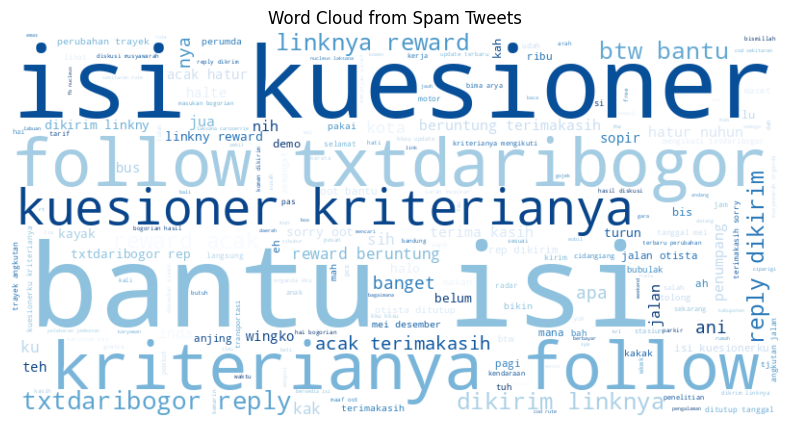

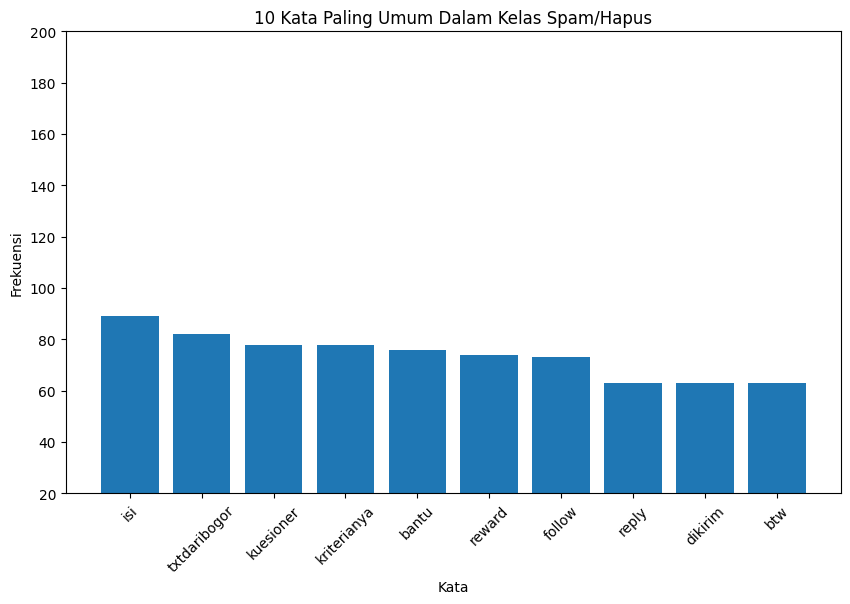

[('isi', 89), ('txtdaribogor', 82), ('kuesioner', 78), ('kriterianya', 78), ('bantu', 76), ('reward', 74), ('follow', 73), ('reply', 63), ('dikirim', 63), ('btw', 63)]


In [ ]:
# Concatenate all tweets into a single string
spam_data = data[data['label-fix'] == 'Spam/Hapus']

# Concatenate all tweets into a single string
all_tweets_text_spam = ' '.join(spam_data['tokenized_without_stemmed'])  # Replace 'tweet_column_name' with the actual column name in your data
cleaned_text_spam = re.sub(r"['\[\],]", "", all_tweets_text_spam)

# Mengabaikan kata 'banget' dan 'angkot'
remove_words = ['instal','aplikasi','mau', 'bisa','bogor', 'orang', 'warga', 'ya', 'kalo', 'tau','biskita', 'transpakuan', 'trans', 'pakuan', 'naik', 'angkot']
cleaned_text_spam = ' '.join([word for word in cleaned_text_spam.split() if word not in remove_words])


# Create a WordCloud object
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text_pos)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      colormap='Blues',   # Warna huruf
                      contour_color='black',  # Warna kontur
                      contour_width=2,       # Lebar kontur
                      mask=None,             # Gunakan mask untuk bentuk kustom
                      ).generate(cleaned_text_spam)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud from Spam Tweets')
plt.axis('off')
plt.show()

words = cleaned_text_spam.split()

word_counts = Counter(words)

# Mengambil 20 kata paling umum
most_common_words = word_counts.most_common(10)

# Memisahkan kata dan frekuensi ke dalam dua list terpisah
common_words, common_counts = zip(*most_common_words)

# Membuat plot
plt.figure(figsize=(10, 6))
plt.bar(common_words, common_counts)
plt.title('10 Kata Paling Umum Dalam Kelas Spam/Hapus')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
# Mengatur rentang dan jarak pada sumbu Y
plt.ylim(20, 200)
plt.yticks(np.arange(20, 201, 20))

plt.xticks(rotation=45)
plt.show()

print(most_common_words)

## Build Model

### Install & Import Dependencies

In [ ]:
!pip install scikit-learn imblearn joblib

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Load dataset

dataset_path = "datasets/tokenized_tweets_modify_okt.csv"
df = pd.read_csv(dataset_path)
df.head(2)

,date,content,tweets-cleaned,tweets-norm,stopwords-remove,stemmed_tweets,tokenized_content,tokenized_without_stemmed,label-fix
0,2023-06-24 23:02:44,"@junehokiw @bogorfess_ kurangg tau kalo itu, c...",kurangg tau kalo itu cuman barusan gua abis da...,kurang tau kalo itu cuman barusan aku habis da...,kurang tau kalo cuman barusan habis udah biski...,kurang tau kalo cuman barusan habis udah biski...,"['kurang', 'tau', 'kalo', 'cuman', 'barusan', ...","['kurang', 'tau', 'kalo', 'cuman', 'barusan', ...",Spam/Hapus
1,2023-06-24 22:45:38,[bgr] biskita jam segini udah ada belum guys??,bgr biskita jam segini udah ada belum guys,bgr biskita jam segini sudah ada belum guys,bgr biskita jam segini belum guys,bgr biskita jam gin belum guys,"['bgr', 'biskita', 'jam', 'gin', 'belum', 'guys']","['bgr', 'biskita', 'jam', 'segini', 'belum', '...",Netral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date                       4094 non-null   object
 1   content                    4094 non-null   object
 2   tweets-cleaned             4090 non-null   object
 3   tweets-norm                4090 non-null   object
 4   stopwords-remove           4090 non-null   object
 5   stemmed_tweets             4090 non-null   object
 6   tokenized_content          4094 non-null   object
 7   tokenized_without_stemmed  4094 non-null   object
 8   label-fix                  4094 non-null   object
dtypes: object(9)
memory usage: 288.0+ KB


In [ ]:
#Remove NaN/Null Values and Spam Class
df_nonnull = df.dropna()

df_filtered = df_nonnull[df_nonnull['label-fix'] != 'Spam/Hapus']
#df_filtered = df_filtered[df_filtered['label-fix'] != 'Netral']

# Print the shape of the filtered DataFrame to verify
print("Shape of filtered DataFrame:", df_filtered.shape)
count_value = df_filtered['label-fix'].value_counts()
print(count_value)

Shape of filtered DataFrame: (3467, 9)
Positif    1318
Netral     1242
Negatif     907
Name: label-fix, dtype: int64


In [ ]:
#Map the class to numeric
label_mapping = {"Negatif": 0, "Netral": 1, "Positif": 2}
df_filtered['label-fix'] = df_filtered['label-fix'].map(label_mapping)

<ipython-input-142-fc79624c656e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label-fix'] = df_filtered['label-fix'].map(label_mapping)


In [ ]:
'''I compared for many reasons, based on accuracy and f1 scores,
when 1 used stemmed column the value is less than when i used tweets-norm  column'''

# Extract features (X) and labels (y)
X = df_filtered['tweets-norm']
y = df_filtered['label-fix']

# Extract features (X) and labels (y)
#X = df_filtered['stopwords-remove']
#y = df_filtered['label-fix']


# Extract features (X) and labels (y)
#X = df_filtered['stemmed_tweets']
#y = df_filtered['label-fix']



### Features Extraction and Visualize top 10 features based on TF IDF scores

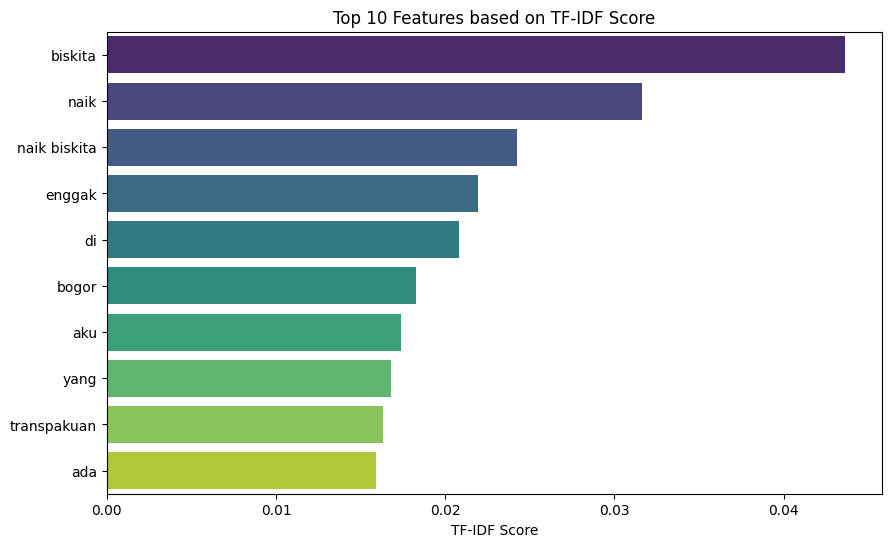

In [ ]:

# Inisialisasi TF-IDF Vectorizer dengan n-gram (1, 1)
tfidf_vectorizer = TfidfVectorizer(max_features = 22500, ngram_range=(1, 2))

# Fit TF-IDF Vectorizer ke data
tfidf_vectorizer.fit(X)

# Transform data
X_tfidf = tfidf_vectorizer.transform(X)

# Buat DataFrame untuk hasil ekstraksi fitur
feature_names = tfidf_vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(data=X_tfidf.toarray(), columns=feature_names)

# Ambil hanya kolom-kolom dengan skor TF-IDF di atas atau sama dengan 0.2
df_tfidf_filtered = df_tfidf.loc[:, (df_tfidf >= 0.2).any()]

# Mengurutkan fitur berdasarkan skor TF-IDF tertinggi
top_10_features = df_tfidf_filtered.mean().sort_values(ascending=False).head(10)

# Print the top 10 features
top_10_features
# Membuat bar plot ke samping dengan seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis', order=top_10_features.index)
plt.xlabel('TF-IDF Score')
plt.title('Top 10 Features based on TF-IDF Score')
plt.show()

### Build Model with K fold Cross Validation to split the data into train-data and test-data, with k = 10 dan implement the SMOTE technique on train-data for handle imbalanced data

In [ ]:

# Inisialisasi model-model
best_params = {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
best_rf_model = RandomForestClassifier(**best_params)
naive_bayes_model = MultinomialNB(alpha=0.1)
logreg_model = LogisticRegression(penalty='l2', C=11.288378916846883, solver='liblinear')

best_rf_model_smote = RandomForestClassifier(**best_params)
naive_bayes_model_smote = MultinomialNB(alpha=0.1)
logreg_model_smote = LogisticRegression(penalty='l2', C=11.288378916846883, solver='liblinear')

# Inisialisasi 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state = 41)

# Inisialisasi list untuk menyimpan hasil evaluasi
accuracy_scores_before_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': [],
    'Ensemble Hard': []
}
accuracy_scores_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': [],
    'Ensemble Hard': []
}

# Inisialisasi list untuk menyimpan hasil evaluasi F1 Score
f1_scores_before_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': [],
    'Ensemble Hard': []
}
f1_scores_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': [],
    'Ensemble Hard': []
}

confusion_matrices_before_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': []
}

confusion_matrices_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': []
}

classification_report_before_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': []
}

classification_report_smote = {
    'Random Forest': [],
    'Naive Bayes': [],
    'Logistic Regression': [],
    'Ensemble': []
}

# Melakukan 10-fold cross-validation
for train_index, test_index in kf.split(X_tfidf):
    X_train_raw, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train_raw, y_test = y.iloc[train_index], y.iloc[test_index]

   # Model Random Forest (sebelum SMOTE)
    best_rf_model.fit(X_train_raw, y_train_raw)
    y_pred_rf = best_rf_model.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    class_report_rf = classification_report(y_test, y_pred_rf)


    f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
    f1_scores_before_smote['Random Forest'].append(f1_rf)

    # Model Naive Bayes (sebelum SMOTE)
    naive_bayes_model.fit(X_train_raw, y_train_raw)
    y_pred_nb = naive_bayes_model.predict(X_test)
    accuracy_nb = accuracy_score(y_test, y_pred_nb)
    confusion_matrix_nb = confusion_matrix(y_test, y_pred_nb)
    class_report_nb = classification_report(y_test, y_pred_nb)


    f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
    f1_scores_before_smote['Naive Bayes'].append(f1_nb)

    # Model Logistic Regression (sebelum SMOTE)
    logreg_model.fit(X_train_raw, y_train_raw)
    y_pred_lr = logreg_model.predict(X_test)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)
    class_report_lr = classification_report(y_test, y_pred_lr)


    f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
    f1_scores_before_smote['Logistic Regression'].append(f1_lr)

    # Model Ensemble sebelum SMOTE
    ensemble_clf_soft = VotingClassifier(
        estimators=[
            ('random_forest', best_rf_model),
            ('naive_bayes', naive_bayes_model),
            ('logistic_regression', logreg_model)
        ],
        voting='soft',
        weights=[accuracy_rf, accuracy_nb, accuracy_lr]
    )

    ensemble_clf_soft.fit(X_train_raw, y_train_raw)
    y_pred_ensemble = ensemble_clf_soft.predict(X_test)
    accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
    confusion_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
    class_report_ensemble = classification_report(y_test, y_pred_ensemble)

    f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')
    f1_scores_before_smote['Ensemble'].append(f1_ensemble)

    # Model Ensemble Hard sebelum SMOTE
    ensemble_clf_hard = VotingClassifier(
        estimators=[
            ('random_forest', best_rf_model),
            ('naive_bayes', naive_bayes_model),
            ('logistic_regression', logreg_model)
        ],
        voting='hard'
    )
    ensemble_clf_hard.fit(X_train_raw, y_train_raw)
    y_pred_ensemble_hard = ensemble_clf_hard.predict(X_test)
    accuracy_ensemble_hard = accuracy_score(y_test, y_pred_ensemble_hard)

    # Perhitungan F1 Score Ensemble Hard (sebelum SMOTE)
    f1_ensemble_hard = f1_score(y_test, y_pred_ensemble_hard, average='weighted')
    f1_scores_before_smote['Ensemble Hard'].append(f1_ensemble_hard)

    # Menyimpan hasil evaluasi
    accuracy_scores_before_smote['Random Forest'].append(accuracy_rf)
    accuracy_scores_before_smote['Logistic Regression'].append(accuracy_lr)
    accuracy_scores_before_smote['Naive Bayes'].append(accuracy_nb)
    accuracy_scores_before_smote['Ensemble'].append(accuracy_ensemble)
    accuracy_scores_before_smote['Ensemble Hard'].append(accuracy_ensemble_hard)

    # ---------------------Terapkan SMOTE hanya pada data latih---------------------------
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # Model Random Forest (setelah SMOTE)
    best_rf_model.fit(X_train, y_train)
    y_pred_rf_smote = best_rf_model.predict(X_test)
    accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
    confusion_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
    class_report_rf_smote = classification_report(y_test, y_pred_rf_smote)


    # Perhitungan F1 Score Random Forest (setelah SMOTE)
    f1_rf_smote = f1_score(y_test, y_pred_rf_smote, average='weighted')
    f1_scores_smote['Random Forest'].append(f1_rf_smote)

    # Model Naive Bayes (setelah SMOTE)
    naive_bayes_model.fit(X_train, y_train)
    y_pred_nb_smote = naive_bayes_model.predict(X_test)
    accuracy_nb_smote = accuracy_score(y_test, y_pred_nb_smote)
    confusion_matrix_nb_smote = confusion_matrix(y_test, y_pred_nb_smote)
    class_report_nb_smote = classification_report(y_test, y_pred_nb_smote)


    # Perhitungan F1 Score Naive Bayes (setelah SMOTE)
    f1_nb_smote = f1_score(y_test, y_pred_nb_smote, average='weighted')
    f1_scores_smote['Naive Bayes'].append(f1_nb_smote)

    # Model Logistic Regression (setelah SMOTE)
    logreg_model.fit(X_train, y_train)
    y_pred_lr_smote = logreg_model.predict(X_test)
    accuracy_lr_smote = accuracy_score(y_test, y_pred_lr_smote)
    confusion_matrix_lr_smote = confusion_matrix(y_test, y_pred_lr_smote)
    class_report_lr_smote = classification_report(y_test, y_pred_lr_smote)


    # Perhitungan F1 Score Logistic Regression (setelah SMOTE)
    f1_lr_smote = f1_score(y_test, y_pred_lr_smote, average='weighted')
    f1_scores_smote['Logistic Regression'].append(f1_lr_smote)

    # Model Ensemble setelah SMOTE
    ensemble_clf_soft_smote = VotingClassifier(
        estimators=[
            ('random_forest', best_rf_model_smote),
            ('naive_bayes', naive_bayes_model_smote),
            ('logistic_regression', logreg_model_smote)
        ],
        voting='soft',
        weights=[accuracy_rf_smote, accuracy_nb_smote, accuracy_lr_smote]
    )

    ensemble_clf_soft_smote.fit(X_train, y_train)
    y_pred_ensemble_smote = ensemble_clf_soft_smote.predict(X_test)
    accuracy_ensemble_smote = accuracy_score(y_test, y_pred_ensemble_smote)
    confusion_matrix_ensemble_smote = confusion_matrix(y_test, y_pred_ensemble_smote)
    class_report_ensemble_smote = classification_report(y_test, y_pred_ensemble_smote)

     # Perhitungan F1 Score Ensemble (setelah SMOTE)
    f1_ensemble_smote = f1_score(y_test, y_pred_ensemble_smote, average='weighted')
    f1_scores_smote['Ensemble'].append(f1_ensemble_smote)

    # Model Ensemble Hard
    ensemble_clf_hard_smote = VotingClassifier(
        estimators=[
            ('random_forest', best_rf_model_smote),
            ('naive_bayes', naive_bayes_model_smote),
            ('logistic_regression', logreg_model_smote)
        ],
        voting='hard'
    )
    ensemble_clf_hard_smote.fit(X_train, y_train)
    y_pred_ensemble_hard_smote = ensemble_clf_hard_smote.predict(X_test)
    accuracy_ensemble_hard_smote = accuracy_score(y_test, y_pred_ensemble_hard_smote)

    # Perhitungan F1 Score Ensemble Hard (setelah SMOTE)
    f1_ensemble_hard_smote = f1_score(y_test, y_pred_ensemble_hard_smote, average='weighted')
    f1_scores_smote['Ensemble Hard'].append(f1_ensemble_hard_smote)


    # Menyimpan hasil evaluasi
    accuracy_scores_smote['Random Forest'].append(accuracy_rf_smote)
    accuracy_scores_smote['Naive Bayes'].append(accuracy_nb_smote)
    accuracy_scores_smote['Logistic Regression'].append(accuracy_lr_smote)
    accuracy_scores_smote['Ensemble'].append(accuracy_ensemble_smote)
    accuracy_scores_smote['Ensemble Hard'].append(accuracy_ensemble_hard_smote)

    confusion_matrices_before_smote['Random Forest'].append(confusion_matrix_rf)
    confusion_matrices_before_smote['Naive Bayes'].append(confusion_matrix_nb)
    confusion_matrices_before_smote['Logistic Regression'].append(confusion_matrix_lr)
    confusion_matrices_before_smote['Ensemble'].append(confusion_matrix_ensemble)

    confusion_matrices_smote['Random Forest'].append(confusion_matrix_rf_smote)
    confusion_matrices_smote['Naive Bayes'].append(confusion_matrix_nb_smote)
    confusion_matrices_smote['Logistic Regression'].append(confusion_matrix_lr_smote)
    confusion_matrices_smote['Ensemble'].append(confusion_matrix_ensemble_smote)

    classification_report_before_smote['Random Forest'].append(class_report_rf)
    classification_report_before_smote['Naive Bayes'].append(class_report_nb)
    classification_report_before_smote['Logistic Regression'].append(class_report_lr)
    classification_report_before_smote['Ensemble'].append(class_report_ensemble)

    classification_report_smote['Random Forest'].append(class_report_rf_smote)
    classification_report_smote['Naive Bayes'].append(class_report_nb_smote)
    classification_report_smote['Logistic Regression'].append(class_report_lr_smote)
    classification_report_smote['Ensemble'].append(class_report_ensemble_smote)



    # Menggunakan fungsi value_counts() untuk menghitung banyaknya masing-masing label
    label_counts = y_train_raw.value_counts()
    label_counts_smote = y_train.value_counts()

    # Membuat dataframe dari hasil perhitungan label
    label_counts_df = pd.DataFrame({'Sebelum SMOTE': label_counts, 'Sesudah SMOTE': label_counts_smote})

    # Menampilkan hasil perhitungan
    print('==============FOLD==============')
    print(label_counts_df)


==============FOLD==============
   Sebelum SMOTE  Sesudah SMOTE
0            815           1195
1           1110           1195
2           1195           1195
==============FOLD==============
   Sebelum SMOTE  Sesudah SMOTE
0            821           1191
1           1108           1191
2           1191           1191
==============FOLD==============
   Sebelum SMOTE  Sesudah SMOTE
0            805           1195
1           1120           1195
2           1195           1195
==============FOLD==============
   Sebelum SMOTE  Sesudah SMOTE
0            825           1184
1           1111           1184
2           1184           1184
==============FOLD==============
   Sebelum SMOTE  Sesudah SMOTE
0            830           1167
1           1123           1167
2           1167           1167
==============FOLD==============
   Sebelum SMOTE  Sesudah SMOTE
0            809           1195
1           1116           1195
2           1195           1195
==============FOLD==============
 

## Model Evaluation

#### Confussion Matrix

Confusion Matrix (ENSEMBLE SMOTE):
 [[ 627  104  176]
 [  79 1016  147]
 [ 125  138 1055]]


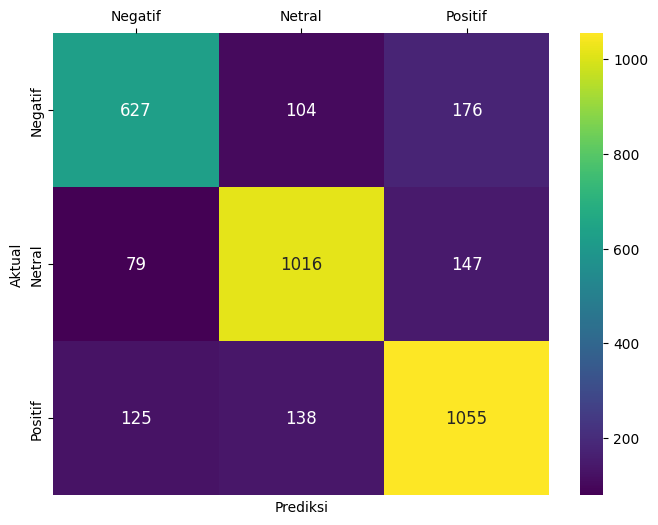

In [ ]:

# Inisialisasi matriks konfusi rata-rata
jumlah_confusion_matrix_ensemble_smote = np.zeros((3,3))

# Menghitung rata-rata matriks konfusi dari hasil cross-validation SMOTE
for cm in confusion_matrices_smote['Ensemble']:
    jumlah_confusion_matrix_ensemble_smote += cm

#umlah_confusion_matrix_ensemble_smote /= len(confusion_matrices_smote['Ensemble'])

# Konversi matriks konfusi rata-rata menjadi integer
jumlah_confusion_matrix_ensemble_smote = jumlah_confusion_matrix_ensemble_smote.astype(int)

# Tampilkan matriks konfusi rata-rata
print("Confusion Matrix (ENSEMBLE SMOTE):\n", jumlah_confusion_matrix_ensemble_smote)

class_names = ['Negatif', 'Netral', 'Positif']

# Visualisasi rata-rata matriks konfusi
plt.figure(figsize=(8, 6))
ax = sns.heatmap(jumlah_confusion_matrix_ensemble_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar  = True, annot_kws={"size": 12})

ax.set(xlabel="Prediksi", ylabel="Aktual")
ax.xaxis.tick_top()


Confusion Matrix (RF SMOTE):
 [[ 526  167  214]
 [  32 1059  151]
 [  85  202 1031]]


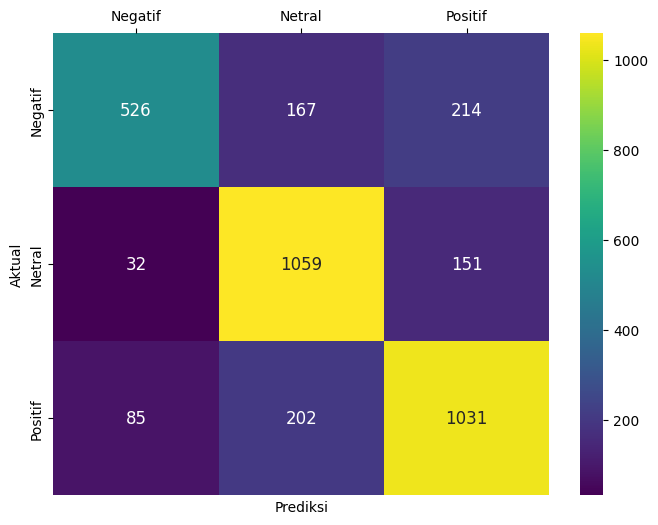

In [ ]:

# Inisialisasi matriks konfusi rata-rata
jumlah_confusion_matrix_rf_smote = np.zeros((3,3))

# Menghitung rata-rata matriks konfusi dari hasil cross-validation SMOTE
for cm in confusion_matrices_smote['Random Forest']:
    jumlah_confusion_matrix_rf_smote += cm

#jumlah_confusion_matrix_rf_smote /= len(confusion_matrices_smote['Random Forest'])

# Konversi matriks konfusi rata-rata menjadi integer
jumlah_confusion_matrix_rf_smote = jumlah_confusion_matrix_rf_smote.astype(int)

# Tampilkan matriks konfusi rata-rata
print("Confusion Matrix (RF SMOTE):\n", jumlah_confusion_matrix_rf_smote)

class_names = ['Negatif', 'Netral', 'Positif']

# Visualisasi rata-rata matriks konfusi
plt.figure(figsize=(8, 6))
ax = sns.heatmap(jumlah_confusion_matrix_rf_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar  = True, annot_kws={"size": 12})

ax.set(xlabel="Prediksi", ylabel="Aktual")
ax.xaxis.tick_top()


Confusion Matrix (NB SMOTE):
 [[ 649   89  169]
 [ 110  949  183]
 [ 190  127 1001]]


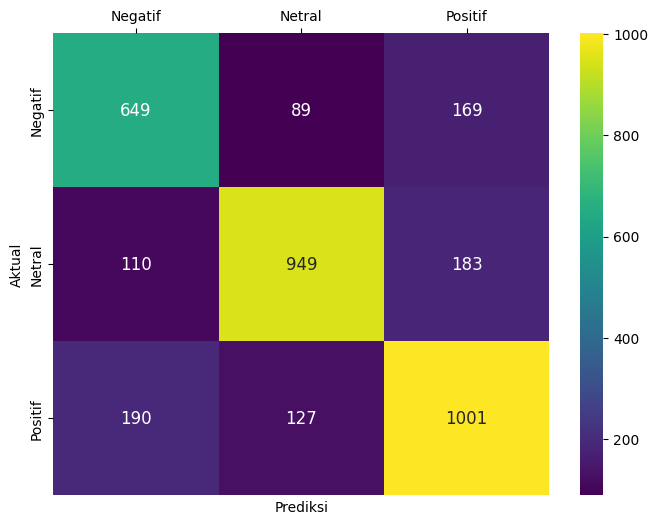

In [ ]:

# Inisialisasi matriks konfusi rata-rata
jumlah_confusion_matrix_nb_smote = np.zeros((3,3))

# Menghitung rata-rata matriks konfusi dari hasil cross-validation SMOTE
for cm in confusion_matrices_smote['Naive Bayes']:
    jumlah_confusion_matrix_nb_smote += cm

#jumlah_confusion_matrix_nb_smote /= len(confusion_matrices_smote['Naive Bayes'])

# Konversi matriks konfusi rata-rata menjadi integer
jumlah_confusion_matrix_nb_smote = jumlah_confusion_matrix_nb_smote.astype(int)

# Tampilkan matriks konfusi rata-rata
print("Confusion Matrix (NB SMOTE):\n", jumlah_confusion_matrix_nb_smote)

class_names = ['Negatif', 'Netral', 'Positif']

# Visualisasi rata-rata matriks konfusi
plt.figure(figsize=(8, 6))
ax = sns.heatmap(jumlah_confusion_matrix_nb_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar  = True, annot_kws={"size": 12})

ax.set(xlabel="Prediksi", ylabel="Aktual")
ax.xaxis.tick_top()


Confusion Matrix (LR SMOTE):
 [[ 604  114  189]
 [  80 1008  154]
 [ 131  129 1058]]


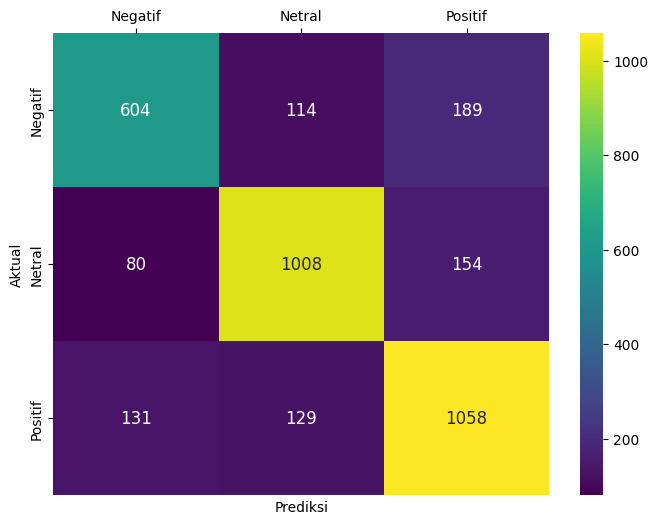

In [ ]:

# Inisialisasi matriks konfusi rata-rata
jumlah_confusion_matrix_lr_smote = np.zeros((3,3))

# Menghitung rata-rata matriks konfusi dari hasil cross-validation SMOTE
for cm in confusion_matrices_smote['Logistic Regression']:
    jumlah_confusion_matrix_lr_smote += cm

#jumlah_confusion_matrix_lr_smote /= len(confusion_matrices_smote['Logistic Regression'])

# Konversi matriks konfusi rata-rata menjadi integer
jumlah_confusion_matrix_lr_smote = jumlah_confusion_matrix_lr_smote.astype(int)

# Tampilkan matriks konfusi rata-rata
print("Confusion Matrix (LR SMOTE):\n", jumlah_confusion_matrix_lr_smote)

class_names = ['Negatif', 'Netral', 'Positif']

# Visualisasi rata-rata matriks konfusi
plt.figure(figsize=(8, 6))
ax = sns.heatmap(jumlah_confusion_matrix_lr_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar  = True, annot_kws={"size": 12})

ax.set(xlabel="Prediksi", ylabel="Aktual")
ax.xaxis.tick_top()


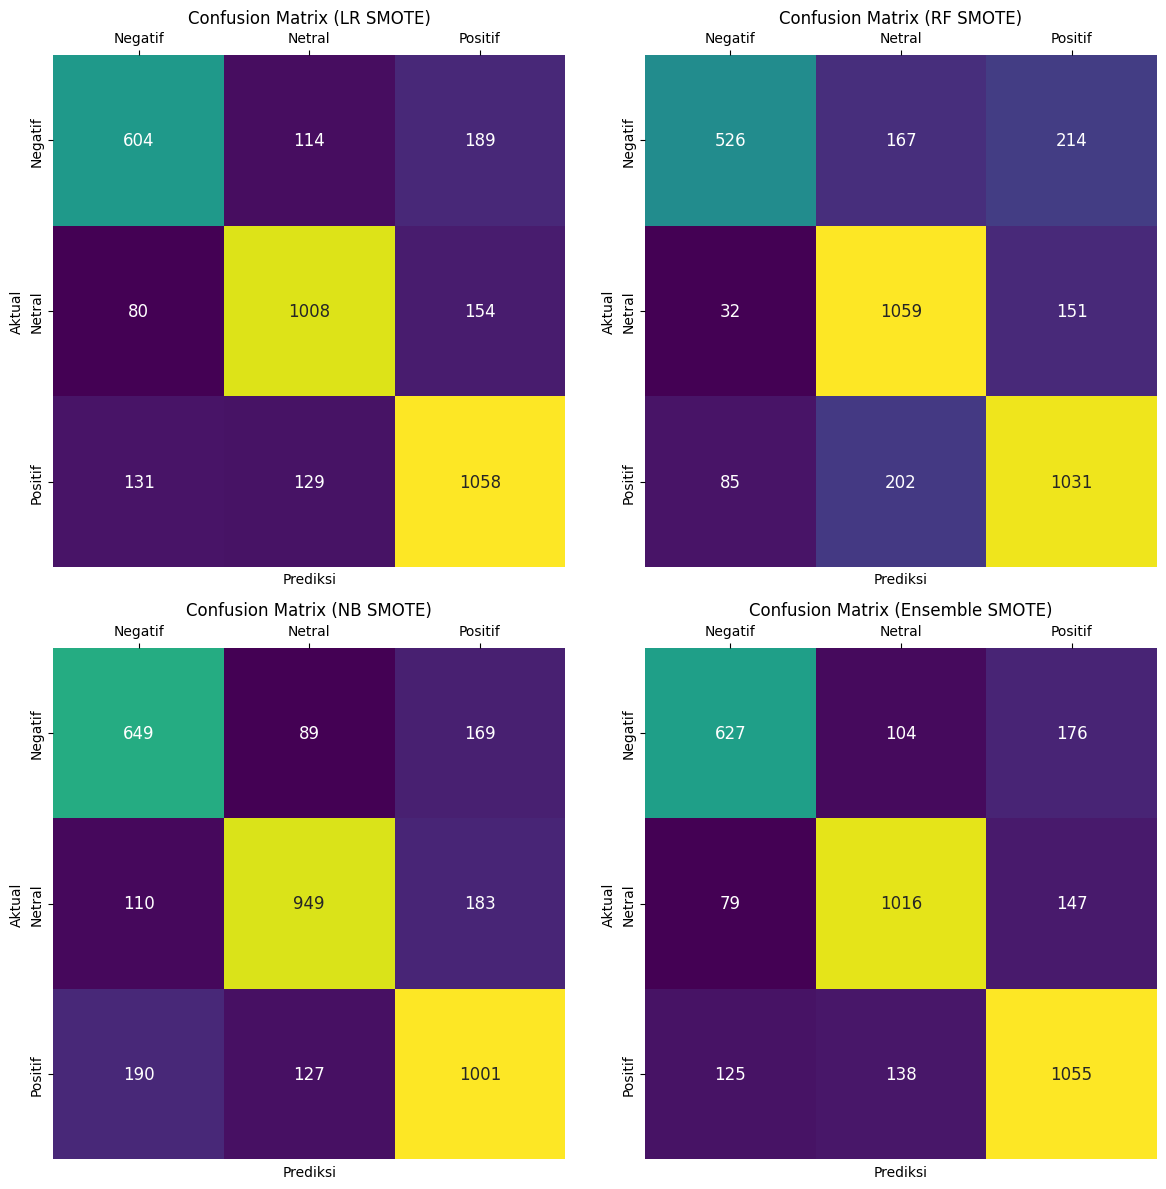

In [ ]:

# Inisialisasi matriks konfusi rata-rata untuk Ensemble, Random Forest, Naive Bayes, dan Logistic Regression
jumlah_confusion_matrix_ensemble_smote = np.zeros((3, 3))
jumlah_confusion_matrix_rf_smote = np.zeros((3, 3))
jumlah_confusion_matrix_nb_smote = np.zeros((3, 3))
jumlah_confusion_matrix_lr_smote = np.zeros((3, 3))

# Menghitung matriks konfusi dari hasil cross-validation SMOTE untuk Ensemble
for cm in confusion_matrices_smote['Ensemble']:
    jumlah_confusion_matrix_ensemble_smote += cm

# Menghitung matriks konfusi dari hasil cross-validation SMOTE untuk Random Forest
for cm in confusion_matrices_smote['Random Forest']:
    jumlah_confusion_matrix_rf_smote += cm

# Menghitung matriks konfusi dari hasil cross-validation SMOTE untuk Naive Bayes
for cm in confusion_matrices_smote['Naive Bayes']:
    jumlah_confusion_matrix_nb_smote += cm

# Menghitung matriks konfusi dari hasil cross-validation SMOTE untuk Logistic Regression
for cm in confusion_matrices_smote['Logistic Regression']:
    jumlah_confusion_matrix_lr_smote += cm

# Konversi matriks konfusi rata-rata menjadi integer
jumlah_confusion_matrix_ensemble_smote = jumlah_confusion_matrix_ensemble_smote.astype(int)
jumlah_confusion_matrix_rf_smote = jumlah_confusion_matrix_rf_smote.astype(int)
jumlah_confusion_matrix_nb_smote = jumlah_confusion_matrix_nb_smote.astype(int)
jumlah_confusion_matrix_lr_smote = jumlah_confusion_matrix_lr_smote.astype(int)

# Tampilkan matriks konfusi dalam grid
class_names = ['Negatif', 'Netral', 'Positif']

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Visualisasi matriks konfusi Ensemble
sns.heatmap(jumlah_confusion_matrix_lr_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axes[0, 0], square=True, annot_kws={"size": 12})
axes[0, 0].set(xlabel="Prediksi", ylabel="Aktual")
axes[0, 0].xaxis.tick_top()
axes[0, 0].set_title("Confusion Matrix (LR SMOTE)")

# Visualisasi matriks konfusi Random Forest
sns.heatmap(jumlah_confusion_matrix_rf_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axes[0, 1], square=True, annot_kws={"size": 12})
axes[0, 1].set(xlabel="Prediksi", ylabel="Aktual")
axes[0, 1].xaxis.tick_top()
axes[0, 1].set_title("Confusion Matrix (RF SMOTE)")

# Visualisasi matriks konfusi Naive Bayes
sns.heatmap(jumlah_confusion_matrix_nb_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axes[1, 0], square=True, annot_kws={"size": 12})
axes[1, 0].set(xlabel="Prediksi", ylabel="Aktual")
axes[1, 0].xaxis.tick_top()
axes[1, 0].set_title("Confusion Matrix (NB SMOTE)")

# Visualisasi matriks konfusi Logistic Regression
sns.heatmap(jumlah_confusion_matrix_ensemble_smote, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names, yticklabels=class_names, cbar=False, ax=axes[1, 1], square=True, annot_kws={"size": 12})
axes[1, 1].set(xlabel="Prediksi", ylabel="Aktual")
axes[1, 1].xaxis.tick_top()
axes[1, 1].set_title("Confusion Matrix (Ensemble SMOTE)")

plt.tight_layout()
plt.show()  # Display the grid of confusion matrices


#### Akurasi tanpa SMOTE

In [ ]:
# Menampilkan hasil evaluasi before SMOTE
evaluation_before_smote_results = {
    'Model': ['Random Forest', 'Naive Bayes', 'Logistic Regression', 'Ensemble', 'Ensemble Hard'],
    'Fold 1': [accuracy_scores_before_smote['Random Forest'][0], accuracy_scores_before_smote['Naive Bayes'][0], accuracy_scores_before_smote['Logistic Regression'][0], accuracy_scores_before_smote['Ensemble'][0], accuracy_scores_before_smote['Ensemble Hard'][0]],
    'Fold 2': [accuracy_scores_before_smote['Random Forest'][1], accuracy_scores_before_smote['Naive Bayes'][1], accuracy_scores_before_smote['Logistic Regression'][1], accuracy_scores_before_smote['Ensemble'][1], accuracy_scores_before_smote['Ensemble Hard'][1]],
    'Fold 3': [accuracy_scores_before_smote['Random Forest'][2], accuracy_scores_before_smote['Naive Bayes'][2], accuracy_scores_before_smote['Logistic Regression'][2], accuracy_scores_before_smote['Ensemble'][2], accuracy_scores_before_smote['Ensemble Hard'][2]],
    'Fold 4': [accuracy_scores_before_smote['Random Forest'][3], accuracy_scores_before_smote['Naive Bayes'][3], accuracy_scores_before_smote['Logistic Regression'][3], accuracy_scores_before_smote['Ensemble'][3], accuracy_scores_before_smote['Ensemble Hard'][3]],
    'Fold 5': [accuracy_scores_before_smote['Random Forest'][4], accuracy_scores_before_smote['Naive Bayes'][4], accuracy_scores_before_smote['Logistic Regression'][4], accuracy_scores_before_smote['Ensemble'][4], accuracy_scores_before_smote['Ensemble Hard'][4]],
    'Fold 6': [accuracy_scores_before_smote['Random Forest'][5], accuracy_scores_before_smote['Naive Bayes'][5], accuracy_scores_before_smote['Logistic Regression'][5], accuracy_scores_before_smote['Ensemble'][5], accuracy_scores_before_smote['Ensemble Hard'][5]],
    'Fold 7': [accuracy_scores_before_smote['Random Forest'][6], accuracy_scores_before_smote['Naive Bayes'][6], accuracy_scores_before_smote['Logistic Regression'][6], accuracy_scores_before_smote['Ensemble'][6], accuracy_scores_before_smote['Ensemble Hard'][6]],
    'Fold 8': [accuracy_scores_before_smote['Random Forest'][7], accuracy_scores_before_smote['Naive Bayes'][7], accuracy_scores_before_smote['Logistic Regression'][7], accuracy_scores_before_smote['Ensemble'][7], accuracy_scores_before_smote['Ensemble Hard'][7]],
    'Fold 9': [accuracy_scores_before_smote['Random Forest'][8], accuracy_scores_before_smote['Naive Bayes'][8], accuracy_scores_before_smote['Logistic Regression'][8], accuracy_scores_before_smote['Ensemble'][8], accuracy_scores_before_smote['Ensemble Hard'][8]],
    'Fold 10': [accuracy_scores_before_smote['Random Forest'][9], accuracy_scores_before_smote['Naive Bayes'][9], accuracy_scores_before_smote['Logistic Regression'][9], accuracy_scores_before_smote['Ensemble'][9], accuracy_scores_before_smote['Ensemble Hard'][9]],
    'Rata-rata': [
        np.mean(accuracy_scores_before_smote['Random Forest']),
        np.mean(accuracy_scores_before_smote['Naive Bayes']),
        np.mean(accuracy_scores_before_smote['Logistic Regression']),
        np.mean(accuracy_scores_before_smote['Ensemble']),
        np.mean(accuracy_scores_before_smote['Ensemble Hard'])
    ]
}

# Membuat DataFrame dari dictionary
evaluation_before_smote_df = pd.DataFrame(evaluation_before_smote_results)

# Menampilkan DataFrame
print("Hasil Evaluasi Sebelum SMOTE:")
evaluation_before_smote_df


Hasil Evaluasi Sebelum SMOTE:


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Rata-rata
0,Random Forest,0.746398,0.737752,0.688761,0.740634,0.760807,0.723343,0.760807,0.809249,0.722543,0.728324,0.741862
1,Naive Bayes,0.740634,0.752161,0.714697,0.760807,0.780980,0.746398,0.769452,0.791908,0.771676,0.725434,0.755415
2,Logistic Regression,0.755043,0.760807,0.729107,0.778098,0.795389,0.740634,0.804035,0.835260,0.774566,0.745665,0.771860
3,Ensemble,0.755043,0.769452,0.743516,0.778098,0.778098,0.760807,0.792507,0.841040,0.791908,0.739884,0.775035
4,Ensemble Hard,0.757925,0.752161,0.752161,0.775216,0.789625,0.763689,0.786744,0.838150,0.789017,0.745665,0.775035


#### Akurasi SMOTE

In [ ]:

# Menampilkan hasil evaluasi SMOTE
evaluation_smote_results = {
    'Model': ['Random Forest', 'Naive Bayes', 'Logistic Regression', 'Ensemble', 'Ensemble Hard'],
    'Fold 1': [accuracy_scores_smote['Random Forest'][0], accuracy_scores_smote['Naive Bayes'][0], accuracy_scores_smote['Logistic Regression'][0], accuracy_scores_smote['Ensemble'][0], accuracy_scores_smote['Ensemble Hard'][0]],
    'Fold 2': [accuracy_scores_smote['Random Forest'][1], accuracy_scores_smote['Naive Bayes'][1], accuracy_scores_smote['Logistic Regression'][1], accuracy_scores_smote['Ensemble'][1], accuracy_scores_smote['Ensemble Hard'][1]],
    'Fold 3': [accuracy_scores_smote['Random Forest'][2], accuracy_scores_smote['Naive Bayes'][2], accuracy_scores_smote['Logistic Regression'][2], accuracy_scores_smote['Ensemble'][2], accuracy_scores_smote['Ensemble Hard'][2]],
    'Fold 4': [accuracy_scores_smote['Random Forest'][3], accuracy_scores_smote['Naive Bayes'][3], accuracy_scores_smote['Logistic Regression'][3], accuracy_scores_smote['Ensemble'][3], accuracy_scores_smote['Ensemble Hard'][3]],
    'Fold 5': [accuracy_scores_smote['Random Forest'][4], accuracy_scores_smote['Naive Bayes'][4], accuracy_scores_smote['Logistic Regression'][4], accuracy_scores_smote['Ensemble'][4], accuracy_scores_smote['Ensemble Hard'][4]],
    'Fold 6': [accuracy_scores_smote['Random Forest'][5], accuracy_scores_smote['Naive Bayes'][5], accuracy_scores_smote['Logistic Regression'][5], accuracy_scores_smote['Ensemble'][5], accuracy_scores_smote['Ensemble Hard'][5]],
    'Fold 7': [accuracy_scores_smote['Random Forest'][6], accuracy_scores_smote['Naive Bayes'][6], accuracy_scores_smote['Logistic Regression'][6], accuracy_scores_smote['Ensemble'][6], accuracy_scores_smote['Ensemble Hard'][6]],
    'Fold 8': [accuracy_scores_smote['Random Forest'][7], accuracy_scores_smote['Naive Bayes'][7], accuracy_scores_smote['Logistic Regression'][7], accuracy_scores_smote['Ensemble'][7], accuracy_scores_smote['Ensemble Hard'][7]],
    'Fold 9': [accuracy_scores_smote['Random Forest'][8], accuracy_scores_smote['Naive Bayes'][8], accuracy_scores_smote['Logistic Regression'][8], accuracy_scores_smote['Ensemble'][8], accuracy_scores_smote['Ensemble Hard'][8]],
    'Fold 10': [accuracy_scores_smote['Random Forest'][9], accuracy_scores_smote['Naive Bayes'][9], accuracy_scores_smote['Logistic Regression'][9], accuracy_scores_smote['Ensemble'][9], accuracy_scores_smote['Ensemble Hard'][9]],
    'Rata-rata': [
        np.mean(accuracy_scores_smote['Random Forest']),
        np.mean(accuracy_scores_smote['Naive Bayes']),
        np.mean(accuracy_scores_smote['Logistic Regression']),
        np.mean(accuracy_scores_smote['Ensemble']),
        np.mean(accuracy_scores_smote['Ensemble Hard'])
    ]
}

# Membuat DataFrame dari dictionary
evaluation_smote_df = pd.DataFrame(evaluation_smote_results)

# Menampilkan DataFrame
evaluation_smote_df


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Rata-rata
0,Random Forest,0.757925,0.775216,0.729107,0.772334,0.755043,0.737752,0.752161,0.820809,0.728324,0.716763,0.754543
1,Naive Bayes,0.746398,0.749280,0.726225,0.752161,0.778098,0.763689,0.760807,0.768786,0.731214,0.719653,0.749631
2,Logistic Regression,0.755043,0.763689,0.740634,0.775216,0.792507,0.717579,0.806916,0.823699,0.786127,0.739884,0.770130
3,Ensemble,0.772334,0.778098,0.749280,0.772334,0.786744,0.755043,0.804035,0.826590,0.797688,0.739884,0.778203
4,Ensemble Hard,0.763689,0.760807,0.760807,0.772334,0.789625,0.746398,0.801153,0.815029,0.786127,0.728324,0.772429


#### Akurasi tanpa dan dengan SMOTE

In [ ]:

# Menambahkan kata "SMOTE" pada nama model pada dataframe hasil evaluasi SMOTE
evaluation_smote_df['Model'] = evaluation_smote_df['Model'] + ' SMOTE'

# Menggabungkan dataframe hasil evaluasi before SMOTE dan hasil evaluasi SMOTE
combined_evaluation_df = pd.concat([evaluation_before_smote_df, evaluation_smote_df])

# Menambahkan baris "Rata-rata" dengan nilai rata-rata dari kolom "Fold"
combined_evaluation_df.loc['Rata-rata'] = combined_evaluation_df[['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10']].mean()
# Reset index untuk DataFrame gabungan
combined_evaluation_df = combined_evaluation_df.reset_index(drop=True)

# Menampilkan DataFrame gabungan yang sudah termasuk baris "Rata-rata"
print("Hasil Evaluasi Sebelum dan Setelah SMOTE:")
combined_evaluation_df


Hasil Evaluasi Sebelum dan Setelah SMOTE:


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Rata-rata
0,Random Forest,0.746398,0.737752,0.688761,0.740634,0.760807,0.723343,0.760807,0.809249,0.722543,0.728324,0.741862
1,Naive Bayes,0.740634,0.752161,0.714697,0.760807,0.780980,0.746398,0.769452,0.791908,0.771676,0.725434,0.755415
2,Logistic Regression,0.755043,0.760807,0.729107,0.778098,0.795389,0.740634,0.804035,0.835260,0.774566,0.745665,0.771860
3,Ensemble,0.755043,0.769452,0.743516,0.778098,0.778098,0.760807,0.792507,0.841040,0.791908,0.739884,0.775035
4,Ensemble Hard,0.757925,0.752161,0.752161,0.775216,0.789625,0.763689,0.786744,0.838150,0.789017,0.745665,0.775035
5,Random Forest SMOTE,0.757925,0.775216,0.729107,0.772334,0.755043,0.737752,0.752161,0.820809,0.728324,0.716763,0.754543
6,Naive Bayes SMOTE,0.746398,0.749280,0.726225,0.752161,0.778098,0.763689,0.760807,0.768786,0.731214,0.719653,0.749631
7,Logistic Regression SMOTE,0.755043,0.763689,0.740634,0.775216,0.792507,0.717579,0.806916,0.823699,0.786127,0.739884,0.770130
8,Ensemble SMOTE,0.772334,0.778098,0.749280,0.772334,0.786744,0.755043,0.804035,0.826590,0.797688,0.739884,0.778203
9,Ensemble Hard SMOTE,0.763689,0.760807,0.760807,0.772334,0.789625,0.746398,0.801153,0.815029,0.786127,0.728324,0.772429


#### F1-Score

In [ ]:
import pandas as pd

# Data evaluasi F1 Score sebelum SMOTE
f1_scores_before_smote_data = {
    'Model': list(f1_scores_before_smote.keys()),
    'Fold 1': [scores[0] for scores in f1_scores_before_smote.values()],
    'Fold 2': [scores[1] for scores in f1_scores_before_smote.values()],
    'Fold 3': [scores[2] for scores in f1_scores_before_smote.values()],
    'Fold 4': [scores[3] for scores in f1_scores_before_smote.values()],
    'Fold 5': [scores[4] for scores in f1_scores_before_smote.values()],
    'Fold 6': [scores[5] for scores in f1_scores_before_smote.values()],
    'Fold 7': [scores[6] for scores in f1_scores_before_smote.values()],
    'Fold 8': [scores[7] for scores in f1_scores_before_smote.values()],
    'Fold 9': [scores[8] for scores in f1_scores_before_smote.values()],
    'Fold 10': [scores[9] for scores in f1_scores_before_smote.values()],
    'Rata-rata': [sum(scores) / 10 for scores in f1_scores_before_smote.values()]
}

# Membuat DataFrame
f1_scores_before_smote_df = pd.DataFrame(f1_scores_before_smote_data)

f1_scores_before_smote_df

,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Rata-rata
0,Random Forest,0.735961,0.731286,0.674592,0.731542,0.748148,0.707298,0.749241,0.804970,0.714709,0.719159,0.731691
1,Naive Bayes,0.740104,0.752057,0.714300,0.760967,0.780679,0.745111,0.770033,0.792747,0.772108,0.726115,0.755422
2,Logistic Regression,0.753987,0.758687,0.725139,0.775613,0.791994,0.735310,0.803803,0.834626,0.773634,0.742865,0.769566
3,Ensemble,0.753572,0.767600,0.741231,0.775758,0.776642,0.756129,0.792163,0.840957,0.791245,0.737923,0.773322
4,Ensemble Hard,0.754153,0.749847,0.749151,0.772571,0.786358,0.758755,0.786301,0.837929,0.788144,0.743642,0.772685


In [ ]:
# Data evaluasi F1 Score setelah SMOTE
f1_scores_smote_data = {
    'Model': list(f1_scores_smote.keys()),
    'Fold 1': [scores[0] for scores in f1_scores_smote.values()],
    'Fold 2': [scores[1] for scores in f1_scores_smote.values()],
    'Fold 3': [scores[2] for scores in f1_scores_smote.values()],
    'Fold 4': [scores[3] for scores in f1_scores_smote.values()],
    'Fold 5': [scores[4] for scores in f1_scores_smote.values()],
    'Fold 6': [scores[5] for scores in f1_scores_smote.values()],
    'Fold 7': [scores[6] for scores in f1_scores_smote.values()],
    'Fold 8': [scores[7] for scores in f1_scores_smote.values()],
    'Fold 9': [scores[8] for scores in f1_scores_smote.values()],
    'Fold 10': [scores[9] for scores in f1_scores_smote.values()],
    'Rata-rata': [sum(scores) / 10 for scores in f1_scores_smote.values()]
}

# Membuat DataFrame
f1_scores_smote_df = pd.DataFrame(f1_scores_smote_data)
f1_scores_smote_df

,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Rata-rata
0,Random Forest,0.752089,0.772680,0.726560,0.769520,0.750985,0.727803,0.748117,0.819168,0.725811,0.711188,0.750392
1,Naive Bayes,0.747617,0.751149,0.726056,0.752912,0.778109,0.763133,0.761512,0.770052,0.732750,0.720292,0.750358
2,Logistic Regression,0.754439,0.762657,0.738554,0.773981,0.790569,0.713662,0.807652,0.823800,0.786099,0.737396,0.768881
3,Ensemble,0.771668,0.777617,0.747366,0.770493,0.786160,0.752379,0.804625,0.826684,0.797511,0.738464,0.777297
4,Ensemble Hard,0.762946,0.759588,0.759148,0.770379,0.787565,0.743707,0.801706,0.815054,0.785340,0.726669,0.771210


In [ ]:
# Menambahkan kata "SMOTE" pada nama model pada dataframe hasil evaluasi SMOTE
f1_scores_smote_df['Model'] = f1_scores_smote_df['Model'] + ' SMOTE'

# Menggabungkan dataframe hasil evaluasi before SMOTE dan hasil evaluasi SMOTE
combined_f1_df = pd.concat([f1_scores_before_smote_df, f1_scores_smote_df])

# Menambahkan baris "Rata-rata" dengan nilai rata-rata dari kolom "Fold"
combined_f1_df.loc['Rata-rata'] = combined_f1_df[['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10']].mean()
# Reset index untuk DataFrame gabungan
combined_f1_df = combined_f1_df.reset_index(drop=True)

# Menampilkan DataFrame gabungan yang sudah termasuk baris "Rata-rata"
print("Hasil F1 Score Sebelum dan Setelah SMOTE:")
combined_f1_df


Hasil F1 Score Sebelum dan Setelah SMOTE:


,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Rata-rata
0,Random Forest,0.735961,0.731286,0.674592,0.731542,0.748148,0.707298,0.749241,0.804970,0.714709,0.719159,0.731691
1,Naive Bayes,0.740104,0.752057,0.714300,0.760967,0.780679,0.745111,0.770033,0.792747,0.772108,0.726115,0.755422
2,Logistic Regression,0.753987,0.758687,0.725139,0.775613,0.791994,0.735310,0.803803,0.834626,0.773634,0.742865,0.769566
3,Ensemble,0.753572,0.767600,0.741231,0.775758,0.776642,0.756129,0.792163,0.840957,0.791245,0.737923,0.773322
4,Ensemble Hard,0.754153,0.749847,0.749151,0.772571,0.786358,0.758755,0.786301,0.837929,0.788144,0.743642,0.772685
5,Random Forest SMOTE,0.752089,0.772680,0.726560,0.769520,0.750985,0.727803,0.748117,0.819168,0.725811,0.711188,0.750392
6,Naive Bayes SMOTE,0.747617,0.751149,0.726056,0.752912,0.778109,0.763133,0.761512,0.770052,0.732750,0.720292,0.750358
7,Logistic Regression SMOTE,0.754439,0.762657,0.738554,0.773981,0.790569,0.713662,0.807652,0.823800,0.786099,0.737396,0.768881
8,Ensemble SMOTE,0.771668,0.777617,0.747366,0.770493,0.786160,0.752379,0.804625,0.826684,0.797511,0.738464,0.777297
9,Ensemble Hard SMOTE,0.762946,0.759588,0.759148,0.770379,0.787565,0.743707,0.801706,0.815054,0.785340,0.726669,0.771210


## Save Models

In [ ]:
import joblib

# Simpan objek X_tfidf
joblib.dump(tfidf_vectorizer, 'kfold_model/X_tfidf_model.joblib')
#WITHOUT SMOTE
joblib.dump(logreg_model, 'kfold_model/logreg_model.joblib')
joblib.dump(naive_bayes_model, 'kfold_model/naive_bayes_model.joblib')
joblib.dump(best_rf_model, 'kfold_model/best_rf_model.joblib')
joblib.dump(ensemble_clf_soft, 'kfold_model/ensemble_clf_soft.joblib')
joblib.dump(ensemble_clf_hard, 'kfold_model/ensemble_clf_hard.joblib')
#SMOTE
joblib.dump(logreg_model_smote, 'kfold_model/logreg_model_smote.joblib')
joblib.dump(naive_bayes_model_smote, 'kfold_model/naive_bayes_model_smote.joblib')
joblib.dump(best_rf_model_smote, 'kfold_model/best_rf_model_smote.joblib')
joblib.dump(ensemble_clf_soft_smote, 'kfold_model/ensemble_clf_soft_smote.joblib')
joblib.dump(ensemble_clf_hard_smote, 'kfold_model/ensemble_clf_hard_smote.joblib')


['kfold_model/ensemble_clf_hard_smote.joblib']

# Summary